This notebook is the amalgamation of isolates-rerun-hierarchical and isolates-99_99pct-rerun-hierarchical.

# 0. Headers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/infant-nt/files/chronostrain.ini
%env CHRONOSTRAIN_DB_JSON=/mnt/e/infant_nt/database/chronostrain_files/efaecalis.json
%env CHRONOSTRAIN_DB_DIR=/mnt/e/infant_nt/database/chronostrain_files
%env CHRONOSTRAIN_CACHE_DIR=./cache
%env CHRONOSTRAIN_LOG_INI=./logging.ini
%env JAX_PLATFORM_NAME=cpu
%env JAX_PLATFORMS=cpu

from typing import *
from pathlib import Path
from helpers import *
from collections import defaultdict
from types import SimpleNamespace
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe
import string

import numpy as np
import scipy
import seaborn as sb
import pandas as pd
from tqdm.notebook import tqdm

from chronostrain.config import cfg
from chronostrain.inference import GaussianWithGlobalZerosPosteriorDense
from chronostrain.model import Strain, TimeSeriesReads
from chronostrain.database import StrainDatabase

env: CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/infant-nt/files/chronostrain.ini
env: CHRONOSTRAIN_DB_JSON=/mnt/e/infant_nt/database/chronostrain_files/efaecalis.json
env: CHRONOSTRAIN_DB_DIR=/mnt/e/infant_nt/database/chronostrain_files
env: CHRONOSTRAIN_CACHE_DIR=./cache
env: CHRONOSTRAIN_LOG_INI=./logging.ini
env: JAX_PLATFORM_NAME=cpu
env: JAX_PLATFORMS=cpu


# 1. Global variables

In [3]:
# ========== data paths
CWD = Path().absolute()
PARTICIPANTS_FILE = CWD.parent / "files" / "all_participants.txt"
#DATA_DIR = Path("/mnt/e/infant_nt")
DATA_DIR = Path("/data/cctm/youn/infant_nt")
MLST_OUTPUT = DATA_DIR / "database" / "chronostrain_files" / "fastmlst" / "fastmlst.tsv"

# ========== database-specific clusters/databases
CHRONOSTRAIN_JSON = DATA_DIR / "database" / "chronostrain_files" / "efaecalis.json"
CHRONOSTRAIN_CLUSTER_TXT = DATA_DIR / "database" / "chronostrain_files" / "efaecalis.clusters.txt"
CHRONOSTRAIN_CLUSTER_99_99PCT_TXT = DATA_DIR / "database" / "chronostrain_files" / "efaecalis.clusters_99_99pct.txt"
CHRONOSTRAIN_CLUSTER_MUTATION_0002 = DATA_DIR / "database" / "mutated_dbs" / "0002" / "chronostrain" / "efaecalis.clusters.txt"
CHRONOSTRAIN_CLUSTER_MUTATION_002 = DATA_DIR / "database" / "mutated_dbs" / "002" / "chronostrain" / "efaecalis.clusters.txt"

MGEMS_CLUSTER = DATA_DIR / "database" / "mgems" / "Efaecalis_elmc_natcom" / "ref_info.tsv"
MGEMS_CLUSTER_MIRROR = DATA_DIR / "database" / "mgems" / "Efaecalis_chrono_mirror" / "ref_info.tsv"
MGEMS_CLUSTER_99_99PCT_MIRROR = DATA_DIR / "database" / "mgems" / "Efaecalis_chrono_99_99pct_mirror" / "ref_info.tsv"
MGEMS_CLUSTER_MUTATION_0002 = DATA_DIR / "database" / "mutated_dbs" / "0002" / "mgems" / "ref_info.tsv"
MGEMS_CLUSTER_MUTATION_002 = DATA_DIR / "database" / "mutated_dbs" / "002" / "mgems" / "ref_info.tsv"

# 2. Load raw results from disk.

## 2.0 Infant catalog

In [4]:
with open("/home/youn/work/chronostrain/examples/infant-nt/files/all_participants.txt", "rt") as f:
    all_infant_ids = [x.strip() for x in f]

print("# infants total:", len(all_infant_ids))


infant_dfs = pd.concat([
    pd.read_csv(DATA_DIR / infant_id / "dataset.tsv", sep='\t')
    for infant_id in all_infant_ids
], ignore_index=True)
display(infant_dfs)

# infants total: 189


,Participant,T,SampleId,Read1,Read2
0,A00021_T1,21.0,SAMEA5616660,/mnt/e/infant_nt/A00021_T1/reads/SAMEA5616660_...,/mnt/e/infant_nt/A00021_T1/reads/SAMEA5616660_...
1,A00021_T2,4.0,SAMEA5616658,/mnt/e/infant_nt/A00021_T2/reads/SAMEA5616658_...,/mnt/e/infant_nt/A00021_T2/reads/SAMEA5616658_...
2,A00021_T2,7.0,SAMEA5616659,/mnt/e/infant_nt/A00021_T2/reads/SAMEA5616659_...,/mnt/e/infant_nt/A00021_T2/reads/SAMEA5616659_...
3,A00021_T2,21.0,SAMEA5616661,/mnt/e/infant_nt/A00021_T2/reads/SAMEA5616661_...,/mnt/e/infant_nt/A00021_T2/reads/SAMEA5616661_...
4,A00031,7.0,SAMEA5616663,/mnt/e/infant_nt/A00031/reads/SAMEA5616663_1.f...,/mnt/e/infant_nt/A00031/reads/SAMEA5616663_2.f...
...,...,...,...,...,...
481,C02566,7.0,SAMEA5618726,/mnt/e/infant_nt/C02566/reads/SAMEA5618726_1.f...,/mnt/e/infant_nt/C02566/reads/SAMEA5618726_2.f...
482,C02571,7.0,SAMEA5618728,/mnt/e/infant_nt/C02571/reads/SAMEA5618728_1.f...,/mnt/e/infant_nt/C02571/reads/SAMEA5618728_2.f...
483,C02695,7.0,SAMEA5618736,/mnt/e/infant_nt/C02695/reads/SAMEA5618736_1.f...,/mnt/e/infant_nt/C02695/reads/SAMEA5618736_2.f...
484,C02756,7.0,SAMEA5618740,/mnt/e/infant_nt/C02756/reads/SAMEA5618740_1.f...,/mnt/e/infant_nt/C02756/reads/SAMEA5618740_2.f...


In [5]:
db = cfg.database_cfg.get_database()
infant_ids = list(get_infant_ids(PARTICIPANTS_FILE))
isolate_df_complete = load_all_isolate_metadata_with_fastmlst(infant_ids, DATA_DIR)

efaecalis_isolate_df = isolate_df_complete.loc[
    (isolate_df_complete['Timepoint'] != 'M')
    & (isolate_df_complete['Genus'] == 'Enterococcus')
    & (isolate_df_complete['Species'] == 'faecalis')
].copy()
efaecalis_isolate_df['Timepoint'] = efaecalis_isolate_df['Timepoint'].astype('float')
efaecalis_isolate_df = efaecalis_isolate_df.rename(columns={
    'Participant': 'Infant',
    'Timepoint': 'T'
})
display(efaecalis_isolate_df)

print("# of non-mother isolates:", efaecalis_isolate_df.loc[efaecalis_isolate_df['T'] != 'M'].shape[0])

,Infant,Accession,FastaPath,Genus,Species,T,SampleId,ST
3,A00021_T1,GCA_902164875,/mnt/e/infant_nt/A00021_T1/isolate_assemblies/...,Enterococcus,faecalis,21.0,4,efaecalis:16
4,A00021_T1,GCA_902164945,/mnt/e/infant_nt/A00021_T1/isolate_assemblies/...,Enterococcus,faecalis,21.0,5,efaecalis:30
10,A00021_T2,GCA_902158995,/mnt/e/infant_nt/A00021_T2/isolate_assemblies/...,Enterococcus,faecalis,7.0,1,efaecalis:30
13,A00021_T2,GCA_902165005,/mnt/e/infant_nt/A00021_T2/isolate_assemblies/...,Enterococcus,faecalis,4.0,*,efaecalis:16
14,A00031,GCA_902164995,/mnt/e/infant_nt/A00031/isolate_assemblies/GCA...,Enterococcus,faecalis,21.0,1,efaecalis:179
...,...,...,...,...,...,...,...,...
778,C02566,GCA_902158985,/mnt/e/infant_nt/C02566/isolate_assemblies/GCA...,Enterococcus,faecalis,7.0,3,efaecalis:145
779,C02566,GCA_902159835,/mnt/e/infant_nt/C02566/isolate_assemblies/GCA...,Enterococcus,faecalis,7.0,1,efaecalis:145
780,C02566,GCA_902159855,/mnt/e/infant_nt/C02566/isolate_assemblies/GCA...,Enterococcus,faecalis,7.0,2,efaecalis:145
791,C02756,GCA_902165575,/mnt/e/infant_nt/C02756/isolate_assemblies/GCA...,Enterococcus,faecalis,7.0,*,efaecalis:179


# of non-mother isolates: 321


## 2.1 mGEMS

### Helper code

In [6]:
def load_msweep_cluster(efaecalis_analysis_name: str) -> pd.DataFrame:
    if efaecalis_analysis_name == 'Efaecalis':
        ref_info_path = MGEMS_CLUSTER
    elif efaecalis_analysis_name == 'Efaecalis_chrono_mirror':
        ref_info_path = MGEMS_CLUSTER_MIRROR
    elif efaecalis_analysis_name == 'Efaecalis_chrono_99_99pct_mirror':
        ref_info_path = MGEMS_CLUSTER_99_99PCT_MIRROR
    elif efaecalis_analysis_name == 'Efaecalis_chrono_mutation_0002':
        ref_info_path = MGEMS_CLUSTER_MUTATION_0002
    elif efaecalis_analysis_name == 'Efaecalis_chrono_mutation_002':
        ref_info_path = MGEMS_CLUSTER_MUTATION_002
    else:
        raise ValueError("Unrecognized efaecalis analysis key {}".format(efaecalis_analysis_name))
        
    ref_info = pd.read_csv(ref_info_path, sep='\t')
    ref_info['cluster'] = ref_info['cluster'].astype(str)
    return ref_info.rename(columns={
        'id': 'Accession',
        'cluster': 'Cluster'
    })[['Accession', 'Cluster']]


def extract_msweep_prediction(
    infant_id: str,
    strain_subdir: str = 'Efaecalis'
) -> Tuple[np.ndarray, List[str], pd.DataFrame, int]:
    # ======= sample metadata
    infant_dir = DATA_DIR / infant_id
    metadata_df = pd.read_csv(infant_dir / "dataset.tsv", sep='\t')
    samples_to_timepoints = {
        str(row['SampleId']): float(row['T'])
        for _, row in metadata_df.iterrows()
    }
    
    # ======= load outputs
    sections = []
    for sample_id, t in samples_to_timepoints.items():
        sample_outdir = infant_dir / "mgems" / sample_id
        species_output_path = sample_outdir / "species" / "msweep_abundances.txt"
        strain_output_path = sample_outdir / strain_subdir / "msweep_abundances.txt"
        demix_check_path = sample_outdir / strain_subdir / "demix_check" / "clu_score.tsv"
        if not strain_output_path.exists():
            raise FileNotFoundError(f"mSWEEP output ({strain_subdir}) for infant {infant_id}, sample {sample_id} (timepoint {t}) not found.")
        if not demix_check_path.exists():
            raise FileNotFoundError(f"QC demix_check output not found for {infant_id}, sample {sample_id} (timepoint {t}).")
        
        sample_res_df = parse_msweep_single(strain_output_path, species_output_path, demix_check_path).assign(T=t)
        sections.append(sample_res_df)
    return pd.concat(sections, ignore_index=True)


class DemixCheckException(BaseException):
    pass


def parse_msweep_single(strain_output_path: Path, species_output_path: Path, demix_check_path: Path) -> pd.DataFrame:
    demix_check_scores = defaultdict(lambda: (5, 0))  # '5' is a fictitious score, even worse than '4' (demix_check didn't run for this cluster). This is a tuple; second entry is the number of binned reads.
    from pandas.errors import EmptyDataError
    try:
        demix_check_df = pd.read_csv(demix_check_path, sep='\t', dtype={'score': 'str'})
    except EmptyDataError:
        raise DemixCheckException(f"demix_check output was empty ({demix_check_path}).")
    if 'cluster' not in demix_check_df.columns:
        raise DemixCheckException("Malformatted demix_check output {}. Found DF indices {}".format(demix_check_path, demix_check_df.columns))
    if demix_check_df.shape[0] == 0:
        raise DemixCheckException(f"demix_check output was empty ({demix_check_path}).")
    for _, row in demix_check_df.iterrows():
        clust_id = str(row['cluster'])
        clust_score = int(row['score'])
        if pd.isna(row['read_count']):
            n_reads = 0
            clust_score = 5  # no binned reads; downgrade the score (demix_check shouldn't have been computed for these)
        else:
            n_reads = int(row['read_count'])
        demix_check_scores[clust_id] = (clust_score, n_reads)

    species_abunds = {}
    with open(species_output_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            species_name, species_abund = line.strip().split("\t")
            species_abunds[species_name] = float(species_abund)
    
    df_entries = []
    with open(strain_output_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            tokens = line.strip().split("\t")
            c_id = tokens[0]
            rel_abund = float(tokens[1])
            efaecalis_abund = species_abunds['Enterococcus_faecalis']
            abund_overall = rel_abund * efaecalis_abund

            score, n_bin_reads = demix_check_scores[c_id]
            df_entries.append({"Cluster": c_id, "Abund": rel_abund, "AbundOverall": abund_overall, "DemixCheckScore": score, "BinnedReads": n_bin_reads})
    
    return pd.DataFrame(df_entries)


def parse_msweep_all(efaecalis_subdir: str = 'Efaecalis', verbose: bool = False) -> Tuple[List[str], pd.DataFrame]:
    msweep_cluster_df = load_msweep_cluster(efaecalis_subdir)
    
    sections = []
    infant_list = []
    for infant_id in all_infant_ids:
        try:
            _df = extract_msweep_prediction(infant_id, strain_subdir=efaecalis_subdir).assign(Infant=infant_id)
            sections.append(_df)
            infant_list.append(infant_id)
        except FileNotFoundError as e:
            if verbose:
                print("[{}]: {}".format(infant_id, e))
            continue
        except DemixCheckException as e:
            if verbose:
                print("[{}]: {}".format(infant_id, e))
            continue

    return infant_list, pd.concat(sections, ignore_index=True), msweep_cluster_df

### Data load

In [7]:
msweep_results_all = {}
print("Loading Efaecalis")
msweep_results_all['Efaecalis'] = parse_msweep_all(efaecalis_subdir='Efaecalis', verbose=False)

print("Loading Efaecalis_chrono_mirror")
msweep_results_all['Efaecalis_chrono_mirror'] = parse_msweep_all(efaecalis_subdir='Efaecalis_chrono_mirror', verbose=False)

print("Loading Efaecalis_chrono_99_99pct_mirror")
msweep_results_all['Efaecalis_chrono_99_99pct_mirror'] = parse_msweep_all(efaecalis_subdir='Efaecalis_chrono_99_99pct_mirror', verbose=False)

print("Loading Efaecalis_chrono_mutation_002")
msweep_results_all['Efaecalis_chrono_mutation_002'] = parse_msweep_all(efaecalis_subdir='Efaecalis_chrono_mutation_002', verbose=False)

for key, (finished_infants, results, clusters) in msweep_results_all.items():
    print(f"[{key}] # mSWEEP Clusters:", len(pd.unique(results['Cluster'])))
    print("[{}] # finished infants: {} / {}".format(key, len(finished_infants), len(all_infant_ids)))
    print("Finished: {}".format(sorted(finished_infants)))
    print("Missing: {}".format(
        sorted(set(all_infant_ids).difference(finished_infants))
    ))
    print()

Loading Efaecalis
Loading Efaecalis_chrono_mirror
Loading Efaecalis_chrono_99_99pct_mirror
Loading Efaecalis_chrono_mutation_002
[Efaecalis] # mSWEEP Clusters: 168
[Efaecalis] # finished infants: 189 / 189
Finished: ['A00021_T1', 'A00021_T2', 'A00031', 'A00043', 'A00067', 'A00106_T1', 'A00106_T2', 'A00185', 'A00190', 'A00219', 'A00502', 'A00559', 'A00576', 'A00908_T1', 'A00947', 'A00995', 'A01011', 'A01057', 'A01077', 'A01082', 'A01105', 'A01107', 'A01166', 'A01173', 'A01176', 'A01301', 'A01311', 'A01506', 'A01563', 'A01580', 'A01583', 'A01586', 'A01639', 'A01653', 'A01671', 'A01676', 'A01678', 'A01687', 'A01739', 'A01802', 'A01805', 'A01862', 'A01866', 'A01921', 'A01939', 'A01966', 'A02053', 'A02110', 'A02133', 'A02138', 'A02819', 'A02913', 'B00002', 'B00010', 'B00012', 'B00013', 'B00016', 'B00020', 'B00027', 'B00036', 'B00046', 'B00053', 'B00071', 'B00076', 'B00085', 'B00088', 'B00090', 'B00092', 'B00096', 'B00097', 'B00100', 'B00101', 'B00111', 'B00116', 'B00119', 'B00129', 'B00136'

## mGEMS species estimates

In [8]:
# msweep species abundances
def extract_msweep_efaec_sample(infant_id: str, sample_id: str) -> float:
    species_output_path = DATA_DIR / infant_id / "mgems" / sample_id / "species" / "msweep_abundances.txt"
    with open(species_output_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            species_name, species_abund = line.strip().split("\t")
            if species_name == 'Enterococcus_faecalis':
                return float(species_abund)

def load_msweep_efaec(infant_list: List[str]) -> pd.DataFrame:
    df_entries = []
    for infant_id in infant_list:
        infant_dataset = pd.read_csv(DATA_DIR / infant_id / 'dataset.tsv', sep='\t')
        for _, row in infant_dataset.iterrows():
            t = row['T']
            sample_id = row['SampleId']
            try:
                efaec_abund = extract_msweep_efaec_sample(infant_id, sample_id)
            except FileNotFoundError:
                print(f"Skipping {infant_id}, sample {sample_id}")
                continue
            df_entries.append({
                'Infant': infant_id,
                'T': t,
                'Efaec': efaec_abund
            })
        
    return pd.DataFrame(df_entries)
msweep_efaec_estimates = load_msweep_efaec(infant_ids)
display(msweep_efaec_estimates)

,Infant,T,Efaec
0,A00021_T1,21.0,2.540660e-07
1,A00021_T2,4.0,8.604500e-09
2,A00021_T2,7.0,2.454530e-02
3,A00021_T2,21.0,2.746620e-08
4,A00031,7.0,7.920740e-09
...,...,...,...
481,C02566,7.0,5.538120e-01
482,C02571,7.0,5.148190e-09
483,C02695,7.0,1.515730e-09
484,C02756,7.0,4.105340e-01


## 2.2 ChronoStrain

### Helper code

In [9]:
# Load the clustering dataframe

def chronostrain_clustering_df(cluster_path: Path):
    df_entries = []
    with open(cluster_path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            tokens = line.strip().split("\t")
            strain_id = tokens[0]
            member_ids = tokens[1].split(",")
            for member_id in member_ids:
                df_entries.append((member_id, strain_id))
    return pd.DataFrame(df_entries, columns=['Accession', 'Cluster'])


def parse_adhoc_clusters(db: StrainDatabase, txt_file: Path) -> Dict[str, Strain]:
    clust = {}
    with open(txt_file, "rt") as f:
        for line in f:
            tokens = line.strip().split(":")
            rep = tokens[0]
            members = tokens[1].split(",")
            for member in members:
                clust[member] = db.get_strain(rep)
    return clust


def parse_strains(db: StrainDatabase, strain_txt: Path):
    with open(strain_txt, 'rt') as f:
        return [
            db.get_strain(l.strip())
            for l in f
        ]


def total_marker_len(strain: Strain) -> int:
    return sum(len(m) for m in strain.markers)


class EmptyReadsException(BaseException):
    pass


def load_chronostrain_posterior(infant_id: str, inference_subdir: str):
    out_dir = DATA_DIR / infant_id / inference_subdir / 'inference'
    if not (out_dir.parent / 'inference.DONE').exists():
        raise FileNotFoundError(f"Inference for {infant_id} not done.")

    input_path = DATA_DIR / infant_id / inference_subdir / 'filtered' / 'filtered_reads.csv'
    reads = TimeSeriesReads.load_from_file(input_path)

    if reads.total_number_reads() == 0:
        raise EmptyReadsException(f"No reads for {infant_id}")
        
    adhoc_clusters: Dict[str, Strain] = parse_adhoc_clusters(db, out_dir / "adhoc_cluster.txt")
    inference_strains: List[Strain] = parse_strains(db, out_dir / 'strains.txt')
    time_points = np.array([reads_t.time_point for reads_t in reads], dtype=float)

    # ======= load the posterior and sample.
    posterior = GaussianWithGlobalZerosPosteriorDense(
        len(inference_strains),
        len(time_points),
        cfg.engine_cfg.dtype
    )
    posterior.load(Path(out_dir / "posterior.{}.npz".format(cfg.engine_cfg.dtype)))
    n_posterior_samples = 5000
    rand = posterior.random_sample(n_posterior_samples)
    g_samples = np.array(posterior.reparametrized_gaussians(rand['std_gaussians'], posterior.get_parameters()))  # T x N x S
    posterior_inclusion_p = scipy.special.expit(-posterior.get_parameters()['gumbel_diff'])
    return reads, time_points, adhoc_clusters, inference_strains, g_samples, posterior_inclusion_p


def load_posterior_filtered_abundances(infant_id: str, inference_subdir: str, posterior_threshold: float):
    # ============== posterior filtered abundances ==================
    reads, time_points, adhoc_clusters, inference_strains, g_samples, posterior_inclusion_p = load_chronostrain_posterior(infant_id, inference_subdir)
    indicators = np.full(g_samples.shape[-1], fill_value=False, dtype=bool)
    indicators[posterior_inclusion_p > posterior_threshold] = True
    
    if np.sum(indicators) == 0:
        pred_abundances = np.full(shape=g_samples.shape, fill_value=np.nan, dtype=float)
    else:
        log_indicators = np.empty(indicators.shape, dtype=float)
        log_indicators[indicators] = 0.0
        log_indicators[~indicators] = -np.inf
        pred_abundances = scipy.special.softmax(g_samples + np.expand_dims(log_indicators, axis=[0, 1]), axis=-1)  # T x N x S

    # Overall (sample-denominated) abundances at the posterior threshold
    if np.sum(indicators) == 0:
        overall_abundances = np.full(shape=g_samples.shape, fill_value=np.nan, dtype=float)
    else:
        num_filtered_reads: np.ndarray = np.array([len(reads_t) for reads_t in reads], dtype=int)
        read_depths: np.ndarray = np.array([reads_t.read_depth for reads_t in reads], dtype=int)
        marker_lens = np.array([total_marker_len(strain) for strain in inference_strains], dtype=int)
        genome_lens = np.array([strain.metadata.total_len for strain in inference_strains], dtype=int)
        marker_ratio = np.reciprocal(np.sum(
            np.expand_dims(marker_lens / genome_lens, axis=[0, 1]) * pred_abundances,
            axis=-1
        ))  # (T x N)
        read_ratio = num_filtered_reads / read_depths  # length T
        weights = marker_ratio * np.expand_dims(read_ratio, axis=1)  # (T x N)
        overall_abundances = pred_abundances * np.expand_dims(weights, axis=2)
    return reads, time_points, adhoc_clusters, inference_strains, g_samples, posterior_inclusion_p, pred_abundances, overall_abundances


def gather_chronostrain_results(
    chronostrain_cluster_df, 
    infant_list: List[str], 
    posterior_threshold: float,
    inference_subdir: str
) -> Tuple[pd.DataFrame, Set[str]]:
    target_df_entries = []
    infant_set = set()
    
    pbar = tqdm(infant_list)
    for infant_id in pbar:
        pbar.set_postfix({"Infant": infant_id})
        try:
            (
                reads, time_points, adhoc_clusters, inference_strains, 
                g_samples, posterior_inclusion_p, 
                pred_abundances, overall_abundances
            ) = load_posterior_filtered_abundances(infant_id, inference_subdir, posterior_threshold)
            infant_set.add(infant_id)
        except FileNotFoundError as e:
            print(e)
            continue
        except EmptyReadsException as e:
            print(e)
            continue

        # Add dictionaries for unwinding adhoc clusters.
        adhoc_membership = {}
        for clust_id, adhoc_rep in adhoc_clusters.items():
            adhoc_membership[adhoc_rep.id] = set(db.get_strain(m) for m, a in adhoc_clusters.items() if a.id == adhoc_rep.id)

        for s_idx, inference_strain in enumerate(inference_strains):
            posterior_p_strain = posterior_inclusion_p[s_idx]
            abund_traj = np.median(
                pred_abundances[:, :, s_idx],  # T x N
                axis=-1
            )
            abund_traj_overall = np.median(
                overall_abundances[:, :, s_idx],  # T x N
                axis=-1
            )
            
            adhoc_members = adhoc_membership[inference_strain.id]
            for pred_t, abund_t, abund_t_overall in zip(time_points, abund_traj, abund_traj_overall):
                for member_clust in adhoc_members:
                    target_df_entries.append({
                        'Infant': infant_id,
                        'Cluster': member_clust.id, 
                        'T': pred_t,
                        'Genus': member_clust.metadata.genus,
                        'Species': member_clust.metadata.species,
                        'Abund': abund_t / len(adhoc_members),
                        'AbundOverall': abund_t_overall,
                        'Posterior': posterior_p_strain,
                        'ClusterSize': chronostrain_cluster_df.loc[chronostrain_cluster_df['Cluster'] == member_clust.id].shape[0]
                    })
    return pd.DataFrame(target_df_entries), infant_set

In [10]:
chronostrain_results_full = defaultdict(lambda: dict())

def _save_chronostrain_table(res_df: pd.DataFrame, infant_ids: List[str], tsv_path: Path, infant_path: Path):
    """
    Takes the resulting DF and saves it to a file.
    """
    res_df.to_csv(tsv_path, index=False, sep='\t')
    with open(infant_path, "wt") as f:
        for iid in infant_ids:
            print(iid, file=f)


def load_cached_chronostrain(inference_subdir: str, q_thresh: float):
    if inference_subdir == "chronostrain":
        clust_df = chronostrain_clustering_df(CHRONOSTRAIN_CLUSTER_TXT)
        cache_dir = Path("tables")  # to re-populate, delete this subdirectory!
    elif inference_subdir == "chronostrain_99_99pct":
        clust_df = chronostrain_clustering_df(CHRONOSTRAIN_CLUSTER_99_99PCT_TXT)
        cache_dir = Path("tables_99_99pct")  # to re-populate, delete this subdirectory!
    elif inference_subdir == "chronostrain_mutation_0002":
        clust_df = chronostrain_clustering_df(CHRONOSTRAIN_CLUSTER_MUTATION_0002)
        cache_dir = Path("tables_mutation_0002")  # to re-populate, delete this subdirectory!
    elif inference_subdir == "chronostrain_mutation_002":
        clust_df = chronostrain_clustering_df(CHRONOSTRAIN_CLUSTER_MUTATION_002)
        cache_dir = Path("tables_mutation_002")  # to re-populate, delete this subdirectory!
    else:
        raise Exception(f"Unrecognized inference run name `{inference_subdir}`")

    cache_dir.mkdir(exist_ok=True)
    q_str = str(q_thresh).replace('.', '_')
    _tsv_path = cache_dir / f"chronostrain.{q_str}.tsv"
    _infant_path = cache_dir / f"chronostrain_infants.{q_str}.txt"
    
    if _tsv_path.exists() and _infant_path.exists():
        print(f"[{inference_subdir}, q={q_thresh}] Loading pre-computed tables from disk.")
        _df = pd.read_csv(_tsv_path, sep='\t')
        with open(_infant_path, "rt") as f:
            _infants = set(l.strip() for l in f if len(l.strip()) > 0)
            print("\t # infants = {} / {}".format(len(_infants), len(all_infant_ids)))

        missing_infant_ids = set(all_infant_ids).difference(_infants)
        if len(missing_infant_ids) > 0:
            print("Attempting to load {} missing infants: {}".format(len(missing_infant_ids), missing_infant_ids))
            _df_new, _infants_new = gather_chronostrain_results(clust_df, missing_infant_ids, q_thresh, inference_subdir)
            print("Found {} new infant results, since the last time this cell was run.".format(len(_infants_new)))
            if len(_infants_new) > 0:
                _df = pd.concat([_df, _df_new], ignore_index=True)
                _infants = _infants.union(_infants_new)
                _save_chronostrain_table(_df, _infants, _tsv_path, _infant_path)
        
        chronostrain_results_full[inference_subdir][q_thresh] = (_df, _infants, clust_df)
    else:
        print(f"[q={q_thresh}] Populating from inference results.")
        _df, _infants = gather_chronostrain_results(clust_df, infant_ids, q_thresh, inference_subdir)
        _save_chronostrain_table(_df, _infants, _tsv_path, _infant_path)
        chronostrain_results_full[inference_subdir][q_thresh] = (_df, _infants, clust_df)
        print("Found {} infant results.".format(len(_infants)))

### Loading

In [11]:
load_cached_chronostrain(inference_subdir="chronostrain", q_thresh=0.90)
load_cached_chronostrain(inference_subdir="chronostrain", q_thresh=0.95)
load_cached_chronostrain(inference_subdir="chronostrain", q_thresh=0.975)
load_cached_chronostrain(inference_subdir="chronostrain", q_thresh=0.99)
load_cached_chronostrain(inference_subdir="chronostrain", q_thresh=0.9925)

# last infants to finish: {'C01695', 'B02588', 'A01687', 'C02059', 'A01966', 'A00502', 'B00036', 'A00947', 'A01506', 'C01919'}
load_cached_chronostrain(inference_subdir="chronostrain_99_99pct", q_thresh=0.90)
load_cached_chronostrain(inference_subdir="chronostrain_99_99pct", q_thresh=0.95)
load_cached_chronostrain(inference_subdir="chronostrain_99_99pct", q_thresh=0.99)

load_cached_chronostrain(inference_subdir="chronostrain_mutation_002", q_thresh=0.90)
load_cached_chronostrain(inference_subdir="chronostrain_mutation_002", q_thresh=0.95)
load_cached_chronostrain(inference_subdir="chronostrain_mutation_002", q_thresh=0.99)

[chronostrain, q=0.9] Loading pre-computed tables from disk.
	 # infants = 189 / 189
[chronostrain, q=0.95] Loading pre-computed tables from disk.
	 # infants = 189 / 189
[chronostrain, q=0.975] Loading pre-computed tables from disk.
	 # infants = 189 / 189
[chronostrain, q=0.99] Loading pre-computed tables from disk.
	 # infants = 189 / 189
[chronostrain, q=0.9925] Loading pre-computed tables from disk.
	 # infants = 189 / 189
[chronostrain_99_99pct, q=0.9] Loading pre-computed tables from disk.
	 # infants = 189 / 189
[chronostrain_99_99pct, q=0.95] Loading pre-computed tables from disk.
	 # infants = 189 / 189
[chronostrain_99_99pct, q=0.99] Loading pre-computed tables from disk.
	 # infants = 189 / 189
[chronostrain_mutation_002, q=0.9] Loading pre-computed tables from disk.
	 # infants = 188 / 189
Attempting to load 1 missing infants: {'B02118'}


  0%|          | 0/1 [00:00<?, ?it/s]

No reads for B02118
Found 0 new infant results, since the last time this cell was run.
[chronostrain_mutation_002, q=0.95] Loading pre-computed tables from disk.
	 # infants = 188 / 189
Attempting to load 1 missing infants: {'B02118'}


  0%|          | 0/1 [00:00<?, ?it/s]

No reads for B02118
Found 0 new infant results, since the last time this cell was run.
[chronostrain_mutation_002, q=0.99] Loading pre-computed tables from disk.
	 # infants = 188 / 189
Attempting to load 1 missing infants: {'B02118'}


  0%|          | 0/1 [00:00<?, ?it/s]

No reads for B02118
Found 0 new infant results, since the last time this cell was run.


## 2.3 Bracken and MetaPhlAn

In [12]:
def load_metaphlan_sample_estimate(infant_id, sample_id):
    metaphlan_outdir = Path("/mnt/e/infant_nt") / infant_id / 'metaphlan' / sample_id
    metaphlan_df = pd.read_csv(metaphlan_outdir / 'profiled_metagenome.txt', sep='\t', comment='#', header=None)
    efaec_hits = metaphlan_df.loc[metaphlan_df[0].str.endswith("s__Enterococcus_faecalis"), 2]
    if efaec_hits.shape[0] == 0:
        return 0.0
    elif efaec_hits.shape[0] == 1:
        return float(efaec_hits.item()) / 100.0
    else:
        raise ValueError("Multiple hits for s__Enterococcus_faecalis")


def load_metaphlan_results_all(infant_list: List[str]):
    df_entries = []
    for infant_id in infant_list:
        # infant_dataset = pd.read_csv(DATA_DIR / infant_id / 'dataset.tsv', sep='\t')
        infant_dataset = pd.read_csv(Path("/mnt/e/infant_nt") / infant_id / 'dataset.tsv', sep='\t')
        for _, row in infant_dataset.iterrows():
            t = row['T']
            sample_id = row['SampleId']
            try:
                efaec_abund = load_metaphlan_sample_estimate(infant_id, sample_id)
            except ValueError:
                print("Problem with parsing metaphlan output for {}, {}".format(infant_id, sample_id))
                raise
            df_entries.append({
                'Infant': infant_id,
                'T': t,
                'Efaec': efaec_abund
            })
    return pd.DataFrame(df_entries)

def load_bracken_sample_estimate(infant_id, sample_id):
    kraken_outdir = DATA_DIR / infant_id / 'kraken' / sample_id
    kraken_outdir = Path("/mnt/e/infant_nt") / infant_id / 'kraken' / sample_id
    bracken_df = pd.read_csv(kraken_outdir / 'bracken.out', sep='\t')
    efaec_abund = float(bracken_df.loc[bracken_df['name'] == 'Enterococcus faecalis', 'fraction_total_reads'].item())
    return efaec_abund


def load_bracken_results_all(infant_list: List[str]):
    df_entries = []
    for infant_id in infant_list:
        # infant_dataset = pd.read_csv(DATA_DIR / infant_id / 'dataset.tsv', sep='\t')
        infant_dataset = pd.read_csv(Path("/mnt/e/infant_nt") / infant_id / 'dataset.tsv', sep='\t')
        for _, row in infant_dataset.iterrows():
            t = row['T']
            sample_id = row['SampleId']
            efaec_abund = load_bracken_sample_estimate(infant_id, sample_id)
            df_entries.append({
                'Infant': infant_id,
                'T': t,
                'Efaec': efaec_abund
            })
    return pd.DataFrame(df_entries)


metaphlan_estimates = load_metaphlan_results_all(infant_ids)
bracken_estimates = load_bracken_results_all(infant_ids)

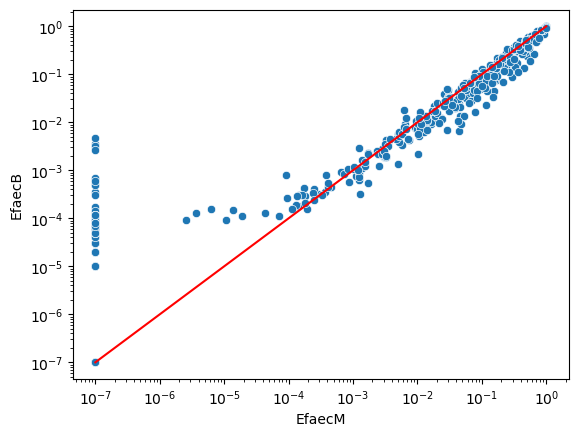

In [13]:
_m = metaphlan_estimates.merge(bracken_estimates, on=['Infant', 'T'], suffixes=['M', 'B'])
_m['EfaecM'] = _m['EfaecM'] + 1e-7
_m['EfaecB'] = _m['EfaecB'] + 1e-7

fig, ax = plt.subplots(1, 1)
sb.scatterplot(_m, x='EfaecM', y='EfaecB', ax=ax)
ax.plot([1e-7, 1.0], [1e-7, 1.0], color='red')
ax.set_xscale('log')
ax.set_yscale('log')

# 3. Plotting code

## helpers

In [14]:
def add_figure_labels(fig, axes, labels=None, x_pos: float = 0.0, y_pos: float = 1.05):
    """ add A/B/C/D labels """
    if labels is None:
        labels = [string.ascii_lowercase[n] for n in range(len(axes))]
    if len(labels) != len(axes):
        raise ValueError("Number of labels do not match number of axes.")
    for n, _ax in enumerate(axes):
        # _ax.text(-.1, 1.1, string.ascii_uppercase[n], transform=_ax.transAxes, size=20, weight='bold')
        trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
        lbl = labels[n]
        _ax.text(
            x_pos, y_pos, lbl, transform=_ax.transAxes + trans,
            va='bottom', fontfamily='sans-serif', weight='bold', size=15
        )

In [15]:
def pick_chronostrain_results(inference_name: str, posterior_threshold: str) -> Tuple[pd.DataFrame, Set[str], pd.DataFrame]:
    """ Loads the appropriate results. """
    if inference_name not in chronostrain_results_full:
        raise ValueError(f"ChronoStrain inference run `{inference_name}` not found.")

    if posterior_threshold not in chronostrain_results_full[inference_name]:
        raise ValueError(f"threshold {posterior_threshold} not evaluated for clustering `{inference_name}`.")

    chronostrain_results, chronostrain_finished_infants, chronostrain_clusters = chronostrain_results_full[inference_name][posterior_threshold]
    return chronostrain_results, chronostrain_finished_infants, chronostrain_clusters


def pick_msweep_results(msweep_key: str) -> Tuple[pd.DataFrame, Set[str], pd.DataFrame]:
    """ Load the appropriate results. """
    if msweep_key not in msweep_results_all:
        raise ValueError(f"mGEMS key {msweep_key} not found.")
        
    msweep_finished_infants, msweep_results, msweep_clusters = msweep_results_all[msweep_key]
    return msweep_results, msweep_finished_infants, msweep_clusters


def threshold_cs_results(res_df, infant_subset, abund_lb) -> pd.DataFrame:
    all_samples = infant_dfs[['Participant', 'T']].rename(columns={'Participant': 'Infant', 'T': 'T'})
    all_samples = all_samples.loc[
        all_samples['Infant'].isin(infant_subset)
    ]
    
    res_thresholded = res_df.loc[
        (res_df['Abund'] > abund_lb)
        & (res_df['Genus'] == 'Enterococcus')
        & (res_df['Species'] == 'faecalis')
    ].groupby(['Infant', 'T'])[['ClusterSize']].apply(
        lambda x: pd.Series({'NumClusters': x['ClusterSize'].shape[0], 'TotalMembers': x['ClusterSize'].sum()})
    ).reset_index()
    
    res_thresholded = res_thresholded.merge(
        all_samples, on=['Infant', 'T'], how='right'
    ).fillna(0)
    return res_thresholded


def threshold_ms_results(res_df, clust_df, infant_subset, abund_lb, demix_check_score_ub_inclusive) -> pd.DataFrame:
    all_samples = infant_dfs[['Participant', 'T']].rename(columns={'Participant': 'Infant', 'T': 'T'})
    all_samples = all_samples.loc[
        all_samples['Infant'].isin(infant_subset)
    ]
    
    res_thresholded = res_df.loc[
        (res_df['Abund'] > abund_lb)
        & (res_df['DemixCheckScore'] <= demix_check_score_ub_inclusive)
    ].merge(
        clust_df.groupby("Cluster")['Accession'].count().rename('ClusterSize').to_frame(),
        on='Cluster'
    ).groupby(['Infant', 'T'])[['ClusterSize']].apply(lambda x: pd.Series({'NumClusters': x['ClusterSize'].shape[0], 'TotalMembers': x['ClusterSize'].sum()})).reset_index()
    
    res_thresholded = res_thresholded.merge(
        all_samples, on=['Infant', 'T'], how='right'
    ).fillna(0)
    return res_thresholded


def match_isolates_chronostrain(chronostrain_df, isolate_df, chronostrain_finished_infants, chronostrain_cluster_df):
    isolate_df = isolate_df.loc[isolate_df['Infant'].isin(chronostrain_finished_infants)]
    
    # How many isolates did chronostrain recover? Look into membership of each called cluster.
    target_df_entries = []
    for infant_id, isolate_section in isolate_df.groupby("Infant"):
        chronostrain_section = chronostrain_df.loc[chronostrain_df['Infant'] == infant_id]
        chronostrain_cluster_ids = set(chronostrain_section['Cluster'])
        
        for isolate_id in isolate_section['Accession']:
            isolate_time_point = float(isolate_section.loc[isolate_section['Accession'] == isolate_id, 'T'].item())
            
            # what is the cluster of this isolate?
            cluster_hit_results = chronostrain_cluster_df.loc[chronostrain_cluster_df['Accession'] == isolate_id, "Cluster"]
            if cluster_hit_results.shape[0] == 0:
                print(f"Isolate {isolate_id} from infant {infant_id} not found in clustering.")
                continue
            target_cluster = cluster_hit_results.item()  # we need to do .startswith() instead of "==" since the accessions have a ".1" suffix at the end.
            target_cluster_sz = chronostrain_cluster_df.loc[chronostrain_cluster_df['Cluster'] == target_cluster].shape[0]
            
            # What did chronostrain predict?
            infant_dir = Path("/mnt/e/infant_nt") / infant_id
            metadata_df = pd.read_csv(infant_dir / "dataset.tsv", sep='\t')
            for pred_t in metadata_df['T']:
                _results = chronostrain_section.loc[
                    (chronostrain_section['Cluster'] == target_cluster) & (chronostrain_section['T'] == pred_t)
                ]
                if _results.shape[0] == 0:
                    abund = 0.0
                    abund_overall = 0.0
                    posterior = 0.0
                else:
                    abund = _results['Abund'].item()
                    abund_overall = _results['AbundOverall'].item()
                    posterior = _results['Posterior'].item()
                # print(isolate_id, target_cluster, abund)
                # raise Exception("ASDF")

                
                target_df_entries.append({
                    'Infant': infant_id,
                    'CultureT': isolate_time_point,
                    'Isolate': isolate_id,
                    'TargetCluster': target_cluster,
                    'PredictionT': pred_t,
                    'Abund': abund,
                    'AbundOverall': abund_overall,
                    'Posterior': posterior,
                    'TargetSize': target_cluster_sz,
                })
    return pd.DataFrame(target_df_entries)


def match_isolates_msweep(msweep_df, isolate_df, msweep_finished_infants, msweep_cluster_df):
    isolate_df = isolate_df.loc[isolate_df['Infant'].isin(msweep_finished_infants)]
    
    # How many isolates did chronostrain recover? Look into membership of each called cluster.
    target_df_entries = []
    for infant_id, isolate_section in isolate_df.groupby("Infant"):
        msweep_section = msweep_df.loc[msweep_df['Infant'] == infant_id]
        msweep_cluster_ids = set(msweep_section['Cluster'])

        for isolate_id in isolate_section['Accession']:
            isolate_time_point = float(isolate_section.loc[isolate_section['Accession'] == isolate_id, 'T'].item())
            
            # what is the cluster of this isolate?
            cluster_hit_results = msweep_cluster_df.loc[msweep_cluster_df['Accession'].str.startswith(isolate_id), "Cluster"]
            if cluster_hit_results.shape[0] == 0:
                print(f"Isolate {isolate_id} from infant {infant_id} not found in clustering.")
                continue
            target_cluster = cluster_hit_results.item()  # we need to do .startswith() instead of "==" since the accessions have a ".1" suffix at the end.
            target_cluster_sz = msweep_cluster_df.loc[msweep_cluster_df['Cluster'] == target_cluster].shape[0]
            
            # What did msweep predict?
            infant_dir = Path("/mnt/e/infant_nt") / infant_id
            metadata_df = pd.read_csv(infant_dir / "dataset.tsv", sep='\t')
            for pred_t in metadata_df['T']:
                hit_row = msweep_section.loc[(msweep_section['Cluster'] == target_cluster) & (msweep_section['T'] == pred_t)]

                if hit_row.shape[0] != 1:
                    display(hit_row)
                    raise Exception(f"Tried to find exact row for target cluster {target_cluster}, but failed (See above dataframe).")
                abund = float(hit_row['Abund'].item())
                abund_overall = float(hit_row['AbundOverall'].item())
                demix_score = int(hit_row['DemixCheckScore'].item())
                
                target_df_entries.append({
                    'Infant': infant_id,
                    'CultureT': isolate_time_point,
                    'Isolate': isolate_id,
                    'TargetCluster': target_cluster,
                    'PredictionT': pred_t,
                    'Abund': abund,
                    'AbundOverall': abund_overall,
                    'DemixCheckScore': demix_score,
                    'TargetSize': target_cluster_sz
                })
    return pd.DataFrame(target_df_entries)

## 3.1 plot counts

### helper code

In [16]:
def compile_results_for_plot(plot_cfg):
    """ Compute dataframes in preparation for plotting. """
    # ================================================================================ setup: Dataframe creations
    # Load the results.
    dfs_to_plot = {}
    for key, sub_cfg in plot_cfg.chronostrain.items():
        target_key = f'chronostrain:{key}'
        print(f"Loading chronostrain key `{target_key}`")
        cs_results, cs_infants, cs_clusters = pick_chronostrain_results(sub_cfg.key, sub_cfg.posterior)
        cs_results_thresholded = cs_results.loc[cs_results['Abund'] > sub_cfg.abund_lb]
        cs_results_thresholded_counts = threshold_cs_results(cs_results, cs_infants, sub_cfg.abund_lb)
        cs_isolates = match_isolates_chronostrain(cs_results, efaecalis_isolate_df, cs_infants, cs_clusters)
        cs_isolates = cs_isolates.assign(
            Found=cs_isolates['Abund'] > sub_cfg.abund_lb
        )
        # within-sample isolate calls.
        cs_isolates_within = cs_isolates.loc[(cs_isolates['CultureT'] == cs_isolates['PredictionT'])]

        # across-sample isolate calls.
        cs_isolates_across = cs_isolates.loc[(cs_isolates['CultureT'] != cs_isolates['PredictionT']) & cs_isolates['Found']]
        
        # Store the results.
        method_name = sub_cfg.name
        dfs_to_plot[target_key] = (
            method_name,
            cs_clusters,
            cs_infants,
            cs_isolates_within,
            cs_isolates_across,
            cs_results,
            cs_results_thresholded,
            cs_results_thresholded_counts,
        )

    for key, sub_cfg in plot_cfg.mgems.items():
        target_key = f'mgems:{key}'
        print(f"Loading mgems key `{target_key}`")
        ms_results, ms_infants, ms_clusters = pick_msweep_results(sub_cfg.key)
        ms_results_thresholded = ms_results.loc[(ms_results['Abund'] > sub_cfg.abund_lb) & (ms_results['DemixCheckScore'] <= sub_cfg.demix_check_ub)]
        ms_results_thresholded_counts = threshold_ms_results(ms_results, ms_clusters, ms_infants, sub_cfg.abund_lb, sub_cfg.demix_check_ub)
        ms_isolates = match_isolates_msweep(ms_results, efaecalis_isolate_df, ms_infants, ms_clusters)
        ms_isolates = ms_isolates.assign(
            Found=(
                (ms_isolates['Abund'] > sub_cfg.abund_lb) 
                & (ms_isolates['DemixCheckScore'] <= sub_cfg.demix_check_ub)
            )
        )
        # within-sample isolate calls.
        ms_isolates_within = ms_isolates.loc[(ms_isolates['CultureT'] == ms_isolates['PredictionT'])]

        # across-sample isolate calls.
        ms_isolates_across = ms_isolates.loc[(ms_isolates['CultureT'] != ms_isolates['PredictionT']) & ms_isolates['Found']]

        # Store the results.
        method_name = sub_cfg.name
        dfs_to_plot[target_key] = (
            method_name,
            ms_clusters,
            ms_infants,
            ms_isolates_within,
            ms_isolates_across,
            ms_results,
            ms_results_thresholded,
            ms_results_thresholded_counts,
        )
    return dfs_to_plot


def plot_isolates_recovered(dfs_to_plot, key_order: List[str], method_palette, ax, isolate_subset=None):
    """
    Render the plot using the results of compile_results_for_plot().
    """
    
    # ================================================================================ PLOT: isolates recovered
    mutual_infants = None
    for key in key_order:
        _, _, method_infants, _, _, _, _, _ = dfs_to_plot[key]
        if mutual_infants is None:
            mutual_infants = set(method_infants)
        else:
            mutual_infants = mutual_infants.intersection(method_infants)
    print("mutual infants:", mutual_infants)

    concat_within_isolates_list = []
    method_order = []
    for key in key_order:
        method_name, _, method_infants, isol_within, _, _, _, _ = dfs_to_plot[key]
        concat_within_isolates_list.append(
            isol_within.loc[
                isol_within['Infant'].isin(mutual_infants), 
                ['Infant', 'PredictionT', 'Isolate', 'Abund', 'AbundOverall', 'Found']
            ].assign(Method=method_name)
        )
        method_order.append(method_name)
    concat_within_isolates = pd.concat(concat_within_isolates_list, ignore_index=True)
    if isolate_subset is not None:
        print("Plotting isolate subset of {} targets.".format(len(isolate_subset)))
        concat_within_isolates = concat_within_isolates.loc[
            concat_within_isolates['Isolate'].isin(isolate_subset)
        ]
    
    _counts = concat_within_isolates.groupby("Method")['Found'].sum().rename('Count')
    _ax = sb.barplot(
        data=_counts.reset_index(),
        x='Method', hue='Method', y='Count',
        ax=ax, palette=method_palette, order=method_order,
    )
    for i in _ax.containers:  # label the heights
        _ax.bar_label(i,)
    ax.set_yticks([])
    
    ax.set_xticks(list(range(len(method_order))))
    #ax.set_xticklabels(method_order, rotation=25, horizontalalignment='center')
    ax.set_xlabel(None)
    ax.set_ylabel('E. faecalis isolates recovered\n(Matching timepoint)')
    ax.set_ylim(0, _counts.max() * 1.1)


def plot_clusters_called(dfs_to_plot, method_order, method_palette, ax):
    """
    Render the plot using the results of compile_results_for_plot().
    """
    # ================================================================================ PLOT: # clusters called
    mutual_infants = None
    for key in key_order:
        _, _, method_infants, _, _, _, _, _ = dfs_to_plot[key]
        if mutual_infants is None:
            mutual_infants = set(method_infants)
        else:
            mutual_infants = mutual_infants.intersection(method_infants)

    concat_thres_results_list = []
    method_order = []
    for key in key_order:
        method_name, _, method_infants, _, _, _, _, thres_res_counts = dfs_to_plot[key]
        concat_thres_results_list.append(
            thres_res_counts.loc[
                thres_res_counts['Infant'].isin(mutual_infants)
            ].assign(Method=method_name)
        )
        method_order.append(method_name)
    concat_thres_results = pd.concat(concat_thres_results_list, ignore_index=True)
    
    sb.boxplot(
        concat_thres_results,
        hue='Method', x='Method', y='NumClusters', 
        ax=ax, palette=method_palette, order=method_order,
        medianprops=dict(color='gold', linewidth=2), showfliers=False, whis=(0.025, 0.975)
    )
    sb.stripplot(
        concat_thres_results,
        hue='Method', x='Method', y='NumClusters', 
        ax=ax, palette=method_palette, order=method_order,
        edgecolor='black', linewidth=0.6, alpha=0.4
    )
    ax.set_ylabel('# Clusters called')
    sections = {
        method: section
        for method, section in concat_thres_results.groupby("Method")
    }
    print("P-values for # clusters called:")
    for (m1, section1), (m2, section2) in itertools.combinations(sections.items(), r=2):
        _, pval = scipy.stats.wilcoxon(
            section1.sort_values(['Infant', 'T'])['NumClusters'].to_numpy(),
            section2.sort_values(['Infant', 'T'])['NumClusters'].to_numpy(),
            alternative='two-sided'
        )
        print("{} vs {} --> {}".format(m1, m2, pval))
        


def plot_genomes_called(dfs_to_plot, method_order, method_palette, ax):
    """
    Render the plot using the results of compile_results_for_plot().
    """
    # ================================================================================ PLOT: # members called
    mutual_infants = None
    for key in key_order:
        _, _, method_infants, _, _, _, _, _ = dfs_to_plot[key]
        if mutual_infants is None:
            mutual_infants = set(method_infants)
        else:
            mutual_infants = mutual_infants.intersection(method_infants)

    concat_thres_results_list = []
    method_order = []
    for key in key_order:
        method_name, _, method_infants, _, _, _, _, thres_res_counts = dfs_to_plot[key]
        concat_thres_results_list.append(
            thres_res_counts.loc[
                thres_res_counts['Infant'].isin(mutual_infants)
            ].assign(Method=method_name)
        )
        method_order.append(method_name)
    concat_thres_results = pd.concat(concat_thres_results_list, ignore_index=True)
    
    sb.boxplot(
        concat_thres_results,
        hue='Method', x='Method', y='TotalMembers', 
        ax=ax, palette=method_palette, order=method_order,
        medianprops=dict(color='gold', linewidth=2), showfliers=False, whis=(0.025, 0.975)
    )
    sb.stripplot(
        concat_thres_results,
        hue='Method', x='Method', y='TotalMembers', 
        ax=ax, palette=method_palette, order=method_order,
        edgecolor='black', linewidth=0.6, alpha=0.4
    )
    ax.set_ylabel('Total # genomes inside called clusters')
    
    sections = {
        method: section
        for method, section in concat_thres_results.groupby("Method")
    }
    print("P-values for # genomes called:")
    for (m1, section1), (m2, section2) in itertools.combinations(sections.items(), r=2):
        _, pval = scipy.stats.wilcoxon(
            section1.sort_values(['Infant', 'T'])['TotalMembers'].to_numpy(),
            section2.sort_values(['Infant', 'T'])['TotalMembers'].to_numpy(),
            alternative='two-sided'
        )
        print("{} vs {} --> {}".format(m1, m2, pval))


def barplot_isolate_calls_within_sample(chronostrain_dfs, mgems_dfs, ax, cs_color='tab:blue', ms_color='tab:orange'):
    """
    This function, unlike the above, requiers that the user pick exactly one ChronoStrain result table and one mGEMS result table.
    The reason is that this tallies up a "Venn diagram" of one, both or neither method calling an isolate.
    """
    (
        _,
        cs_clusters,
        cs_infants,
        cs_isolates_within,
        cs_isolates_across,
        cs_results,
        cs_results_thresholded,
        cs_results_thresholded_counts,
    ) = chronostrain_dfs

    (
        _,
        ms_clusters,
        ms_infants,
        ms_isolates_within,
        ms_isolates_across,
        ms_results,
        ms_results_thresholded,
        ms_results_thresholded_counts,
    ) = mgems_dfs
    
    merged_found = cs_isolates_within[['CultureT', 'Infant', 'Isolate', 'Found', 'Abund', 'AbundOverall', 'Posterior']].merge(
        ms_isolates_within[['CultureT', 'Infant', 'Isolate', 'Found', 'Abund', 'AbundOverall', 'DemixCheckScore']],
        on=['CultureT', 'Infant', 'Isolate'],
        suffixes=['CS', 'MS'],
        how='inner'  # this inner join ensures mutually contained infant sample information.
    )

    # _c = set(cs_isolates_within['Infant'])
    # _m = set(ms_isolates_within['Infant'])
    # print(len(_c), len(_m))
    # print(len(_c.intersection(_m)))
    # print(_c.difference(_m))
    # print(_m.difference(_c))
    # display(merged_found)

    def isolate_found_type(cs_found, ms_found) -> str:
        if cs_found and ms_found:
            return 'Both'
        elif cs_found and not ms_found:
            return 'CS Only'
        elif not cs_found and ms_found:
            return 'mGEMS Only'
        else:
            return 'Neither'
    merged_found['ResultType'] = merged_found.apply(lambda x: isolate_found_type(x['FoundCS'], x['FoundMS']), axis=1)

    # ================================================================================== counts of found isolates
    _counts = merged_found.groupby('ResultType')['Isolate'].count().rename('Count')
    cat_order = ['Both', 'CS Only', 'mGEMS Only', 'Neither']
    palette = {
        'CS Only': cs_color,
        'mGEMS Only': ms_color,
        'Both': 'green',
        'Neither': 'gray'
    }
    for cat in cat_order:
        if cat not in _counts.index:
            _counts.loc[cat] = 0
    
    _ax = sb.barplot(
        data=_counts.reset_index(),
        x='ResultType', hue='ResultType', order=cat_order,
        y='Count',
        palette=palette,
        ax=ax
    )
    for i in _ax.containers:  # label the heights
        _ax.bar_label(i,)
    ax.set_yticks([])
    
    ax.set_xticks(list(range(len(cat_order))))
    ax.set_xticklabels(cat_order, rotation=25, horizontalalignment='center')
    ax.set_xlabel(None)
    ax.set_ylabel('# isolates called\n' + r'$\bf{(within-timepoint)}$')
    ax.set_ylim(0, _counts.max() * 1.1)
    return palette


def barplot_isolate_calls_across_sample(chronostrain_dfs, mgems_dfs, ax, cs_color='tab:blue', ms_color='tab:orange'):
    """
    This function, unlike the above, requiers that the user pick exactly one ChronoStrain result table and one mGEMS result table.
    The reason is that this tallies up a "Venn diagram" of one, both or neither method calling an isolate.
    """
    (
        _,
        cs_clusters,
        cs_infants,
        cs_isolates_within,
        cs_isolates_across,
        cs_results,
        cs_results_thresholded,
        cs_results_thresholded_counts,
    ) = chronostrain_dfs

    (
        _,
        ms_clusters,
        ms_infants,
        ms_isolates_within,
        ms_isolates_across,
        ms_results,
        ms_results_thresholded,
        ms_results_thresholded_counts,
    ) = mgems_dfs
    
    merged_found = cs_isolates_across[['CultureT', 'PredictionT', 'Infant', 'Isolate', 'Found', 'Abund', 'AbundOverall', 'Posterior']].merge(
        ms_isolates_across[['CultureT', 'PredictionT', 'Infant', 'Isolate', 'Found', 'Abund', 'AbundOverall', 'DemixCheckScore']],
        on=['CultureT', 'PredictionT', 'Infant', 'Isolate'],
        suffixes=['CS', 'MS'],
        how='outer'
    )
    merged_found['FoundCS'] = merged_found['FoundCS'].astype('boolean').fillna(False)
    merged_found['FoundMS'] = merged_found['FoundMS'].astype('boolean').fillna(False)
    isolate_cross_grouped = merged_found.groupby(['Infant', 'PredictionT'])[['FoundCS', 'FoundMS']].max().reset_index()

    def isolate_found_type(cs_found, ms_found) -> str:
        if cs_found and ms_found:
            return 'Both'
        elif cs_found and not ms_found:
            return 'CS Only'
        elif not cs_found and ms_found:
            return 'mGEMS Only'
        else:
            return 'Neither'
    isolate_cross_grouped['ResultType'] = isolate_cross_grouped.apply(lambda x: isolate_found_type(x['FoundCS'], x['FoundMS']), axis=1)

    # ================================================================================== counts of found isolates
    _counts = isolate_cross_grouped.groupby('ResultType')['PredictionT'].count().rename('Count')
    cat_order = ['Both', 'CS Only', 'mGEMS Only']
    palette = {
        'CS Only': cs_color,
        'mGEMS Only': ms_color,
        'Both': 'green'
    }
    for cat in cat_order:
        if cat not in _counts.index:
            _counts.loc[cat] = 0
    
    _ax = sb.barplot(
        data=_counts.reset_index(),
        x='ResultType', hue='ResultType', order=cat_order,
        y='Count',
        palette=palette,
        ax=ax
    )
    for i in _ax.containers:  # label the heights
        _ax.bar_label(i,)
    ax.set_yticks([])
    
    ax.set_xticks(list(range(len(cat_order))))
    ax.set_xticklabels(cat_order, rotation=25, horizontalalignment='center')
    ax.set_xlabel(None)
    ax.set_ylabel('# samples w/ called isolates\n' + r'$\bf{(across-timepoint)}$')
    ax.set_ylim(0, _counts.max() * 1.1)

### data precompute & render

In [17]:
key_order = ['chronostrain:coarse_default', 'chronostrain:mut_002', 'mgems:coarse', 'mgems:coarse_no_demix', 'mgems:mut_002_dm2']
# key_order = ['chronostrain:coarse_default', 'mgems:coarse', 'mgems:coarse_no_demix']
method_colors = {
    'CS': 'tab:blue',
    'CS (Strict)': 'blue',
    'CS (Lenient)': 'skyblue',
    'CS (99.99% Clust)': 'darkblue',
    'CS[mut]\n0.002': 'navy',
    'mGEMS-paper': 'orange',
    'mGEMS-paper (no QC)': 'yellow',
    'mGEMS': 'tab:orange',
    'mGEMS (no QC)': 'orangered',
    'mGEMS[mut],0.002,demix<=2': 'red',
    'mGEMS[mut],0.002,demix<=3': 'red',
    'mGEMS[mut],0.002,demix<=4': 'red',
    'mGEMS (fine)': 'red',
}

Loading chronostrain key `chronostrain:coarse_default`
Loading chronostrain key `chronostrain:fine`
Loading chronostrain key `chronostrain:mut_002`
Isolate GCA_902164875 from infant A00021_T1 not found in clustering.
Isolate GCA_902164945 from infant A00021_T1 not found in clustering.
Isolate GCA_902165005 from infant A00021_T2 not found in clustering.
Isolate GCA_902158875 from infant A00502 not found in clustering.
Isolate GCA_902164075 from infant A00502 not found in clustering.
Isolate GCA_902159895 from infant A00559 not found in clustering.
Isolate GCA_902159915 from infant A00559 not found in clustering.
Isolate GCA_902159945 from infant A00559 not found in clustering.
Isolate GCA_902160035 from infant A00559 not found in clustering.
Isolate GCA_902165075 from infant A00576 not found in clustering.
Isolate GCA_902163075 from infant A00908_T1 not found in clustering.
Isolate GCA_902163105 from infant A00908_T1 not found in clustering.
Isolate GCA_902165135 from infant A00908_T1 n

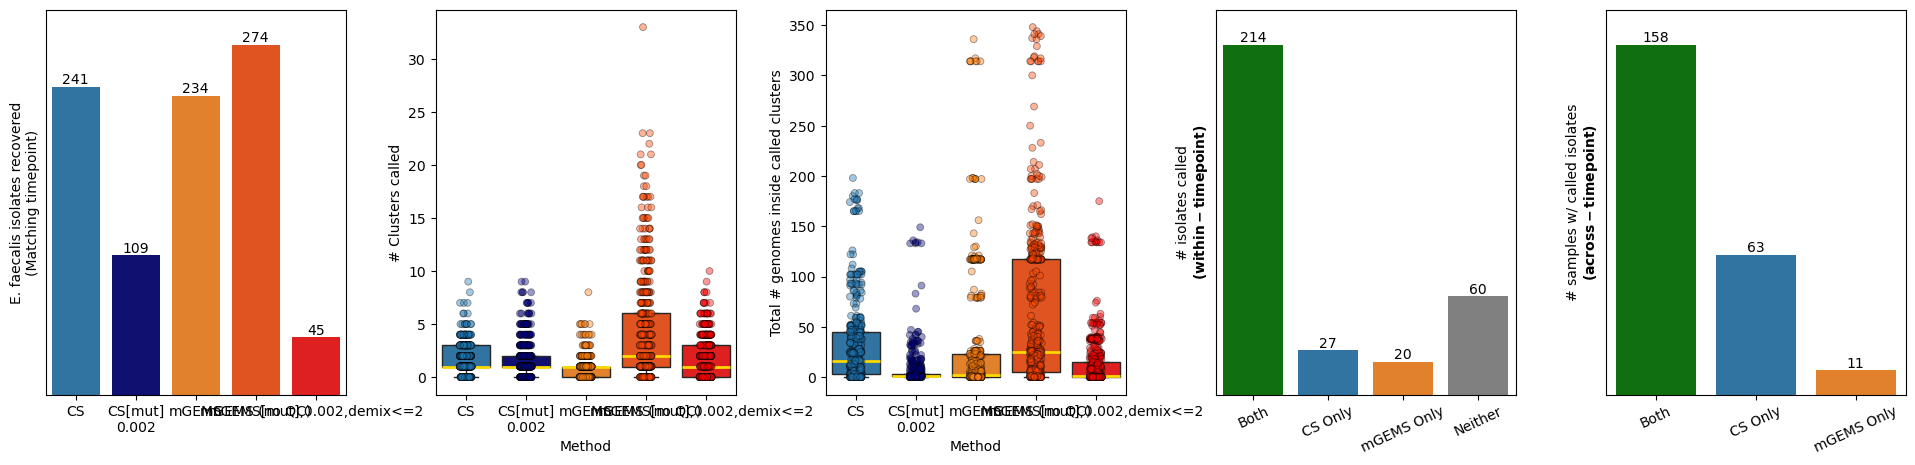

In [18]:
plot_config = SimpleNamespace(
    chronostrain = {
        'coarse_default': SimpleNamespace(name='CS', key="chronostrain", posterior=0.95, abund_lb=0.065),
        # 'coarse_strict': SimpleNamespace(name='CS (Strict)', key="chronostrain", posterior=0.99, abund_lb=0.1),
        # 'coarse_lenient': SimpleNamespace(name='CS (Lenient)', key="chronostrain", posterior=0.95, abund_lb=0.01),
        'fine': SimpleNamespace(name='CS (99.99% Clust)', key="chronostrain_99_99pct", posterior=0.95, abund_lb=0.018),
        'mut_002': SimpleNamespace(name='CS[mut]\n0.002', key="chronostrain_mutation_002", posterior=0.95, abund_lb=0.065),
    },
    mgems = {
        # 'paper': SimpleNamespace(name='mGEMS-paper', key='Efaecalis', abund_lb=0.01, demix_check_ub=2),
        # 'paper_no_demix': SimpleNamespace(name='mGEMS-paper (no QC)', key='Efaecalis', abund_lb=0.01, demix_check_ub=4),
        'coarse': SimpleNamespace(name='mGEMS', key='Efaecalis_chrono_mirror', abund_lb=0.01, demix_check_ub=2),
        'coarse_no_demix': SimpleNamespace(name='mGEMS (no QC)', key='Efaecalis_chrono_mirror', abund_lb=0.01, demix_check_ub=4),
        'mut_002_dm2': SimpleNamespace(name='mGEMS[mut],0.002,demix<=2', key='Efaecalis_chrono_mutation_002', abund_lb=0.01, demix_check_ub=2),
        'mut_002_dm3': SimpleNamespace(name='mGEMS[mut],0.002,demix<=3', key='Efaecalis_chrono_mutation_002', abund_lb=0.01, demix_check_ub=3),
        'mut_002_dm4': SimpleNamespace(name='mGEMS[mut],0.002,demix<=4', key='Efaecalis_chrono_mutation_002', abund_lb=0.01, demix_check_ub=4),
        # 'fine': SimpleNamespace(name='mGEMS (fine)', key='Efaecalis_chrono_99_99pct_mirror', abund_lb=0.01, demix_check_ub=2),
    }
)
# method_order = ['CS', 'CS (Strict)', 'CS (Lenient)', 'CS-Fine', 'mGEMS', 'mGEMS\n(no QC)']
# method_order = ['CS', 'CS (99.99% Clust)', 'mGEMS', 'mGEMS (no QC)']
# method_order = ['CS', 'mGEMS', 'mGEMS (no QC)', 'mGEMS[mut]']

# key_order = ['chronostrain:coarse_default', 'chronostrain:mut', 'mgems:paper', 'mgems:coarse', 'mgems:mut']



matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(24, 5))
gs = gridspec.GridSpec(ncols=5, nrows=1, figure=fig, hspace=0.4, wspace=0.3)
axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[0, 3]),
    fig.add_subplot(gs[0, 4]),
]


dfs_to_plot = compile_results_for_plot(plot_config)  # raw dataframes.


plot_isolates_recovered(dfs_to_plot, key_order, method_colors, axes[0])
plot_clusters_called(dfs_to_plot, key_order, method_colors, axes[1])
plot_genomes_called(dfs_to_plot, key_order, method_colors, axes[2])
barplot_isolate_calls_within_sample(dfs_to_plot['chronostrain:coarse_default'], dfs_to_plot['mgems:coarse'], axes[3])
barplot_isolate_calls_across_sample(dfs_to_plot['chronostrain:coarse_default'], dfs_to_plot['mgems:coarse'], axes[4])

print("Note: panels a/b/c use all-mutually finished infants, panels d/e only use the two.")
plt.show()

## 3.2 Plot timeseries

In [158]:
def plot_chronostrain(infant_id: str, inference_subdir: str, ax, color_scheme, df_tuple, posterior_threshold):
    (
        reads, time_points, adhoc_clusters, inference_strains, 
        g_samples, posterior_inclusion_p, 
        pred_abundances, overall_abundances
    ) = load_posterior_filtered_abundances(infant_id, inference_subdir, posterior_threshold)   # coarse result only
    inference_ordering = {strain.id: s_idx for s_idx, strain in enumerate(inference_strains)}

    _, clustering, infants, isol_within, isol_across, raw_res, thres_res, _ = df_tuple
    if infant_id not in infants:
        raise Exception(f"{infant_id} not in infant list.")
    time_points = sorted(pd.unique(infant_dfs.loc[
        infant_dfs['Participant'] == infant_id,
        'T'
    ]))

    infant_raw_res = raw_res.loc[raw_res['Infant'] == infant_id, :]
    infant_thres_res = thres_res.loc[thres_res['Infant'] == infant_id, :]
    clusters_to_plot = pd.unique(infant_thres_res['Cluster'])
    infant_isolates = set(efaecalis_isolate_df.loc[efaecalis_isolate_df['Infant'] == infant_id, 'Accession'])
    isol_hits = pd.concat([
        isol_within.loc[isol_within['Infant'] == infant_id],
        isol_across.loc[isol_across['Infant'] == infant_id]
    ], ignore_index=True)

    for clust, color in zip(clusters_to_plot, itertools.cycle(color_scheme)):
        if clust not in adhoc_clusters:
            # print(f"Skipping cluster {clust}")
            continue
        s_idx = inference_ordering[adhoc_clusters[clust].id]
        
        clust_members = set(clustering.loc[clustering['Cluster'] == clust, 'Accession'])
        scatter_t_across = []
        scatter_y_across = []
        scatter_t_within = []
        scatter_y_within = []
        # if len(clust_members.intersection(infant_isolates)) > 0:
        #     # this cluster contains an isolate from this infant
        #     linestyle = '-'
        #     z_order = 1
        #     for _, row in isol_hits.loc[isol_hits['TargetCluster'] == clust].iterrows():
        #         culture_t = row['CultureT']
        #         pred_t = row['PredictionT']
        #         if culture_t == pred_t:
        #             scatter_t_within.append(pred_t)
        #             scatter_y_within.append(row['AbundOverall'])
        #         else:
        #             scatter_t_across.append(pred_t)
        #             scatter_y_across.append(row['AbundOverall'])
        # else:
        #     linestyle = '--'
        #     z_order = 0

        if len(clust_members.intersection(infant_isolates)) > 0:
            # this cluster contains an isolate from this infant
            linestyle = '-'
            z_order = 1
            for _, row in isol_hits.loc[isol_hits['TargetCluster'] == clust].iterrows():
                culture_t = row['CultureT']
                pred_t = row['PredictionT']
                if culture_t == pred_t:
                    scatter_t_within.append(pred_t)
                    scatter_y_within.append(row['AbundOverall'])
                else:
                    scatter_t_across.append(pred_t)
                    scatter_y_across.append(row['AbundOverall'])
        else:
            linestyle = '-'
            z_order = 0
            for _, row in thres_res.loc[(thres_res['Cluster'] == clust) & (thres_res['Infant'] == infant_id)].iterrows():
                scatter_t_across.append(row['T'])
                scatter_y_across.append(row['AbundOverall'])
                
        section = infant_raw_res.loc[infant_raw_res['Cluster'] == clust]
        
        trajectory_samples = overall_abundances[:, :, s_idx]
        medians = np.median(trajectory_samples, axis=-1)
        lower = np.quantile(trajectory_samples, axis=-1, q=0.025)
        upper = np.quantile(trajectory_samples, axis=-1, q=0.975)
        ax.plot(time_points, medians, color=color, linestyle=linestyle, zorder=z_order)
        ax.fill_between(time_points, lower, upper, color=color, alpha=0.3, zorder=z_order)
        ax.scatter(scatter_t_across, scatter_y_across, color=color, marker='X', zorder=z_order, s=80, edgecolors='black', linewidth=0.5)
        ax.scatter(scatter_t_within, scatter_y_within, color=color, marker='o', zorder=z_order, s=80, edgecolors='black', linewidth=0.5)
    ax.set_xticks(time_points)

In [20]:
def plot_mgems(infant_id: str, ax, color_scheme, df_tuple, marker_enforce_demix_ub: int = None):
    """
    :param marker_enforce_demix_ub: additionally filter the scatterplot markers by demix_check score <= UB, but ONLY serves as an additional filter AFTER the postprocessing is already done.
        For example: this Does nothing if the input dataframe <df_tuple>'s isol_hits dataframe is already filtered by demix_check score.
    """
    if marker_enforce_demix_ub is not None:
        print(f"Isolate scatterplots will have demix_check score <= {marker_enforce_demix_ub} enforced!")
        
    _, clustering, infants, isol_within, isol_across, raw_res, thres_res, _ = df_tuple
    if infant_id not in infants:
        raise Exception(f"{infant_id} not in infant list.")
    time_points = sorted(pd.unique(infant_dfs.loc[
        infant_dfs['Participant'] == infant_id,
        'T'
    ]))

    infant_raw_res = raw_res.loc[raw_res['Infant'] == infant_id, :]
    infant_thres_res = thres_res.loc[thres_res['Infant'] == infant_id, :]
    clusters_to_plot = pd.unique(infant_thres_res['Cluster'])
    infant_isolates = set(efaecalis_isolate_df.loc[efaecalis_isolate_df['Infant'] == infant_id, 'Accession'])
    isol_hits = pd.concat([
        isol_within.loc[isol_within['Infant'] == infant_id],
        isol_across.loc[isol_across['Infant'] == infant_id]
    ], ignore_index=True)
    # print("mGEMS clusters to plot:", clusters_to_plot)

    colors = iter(color_scheme)
    for clust in clusters_to_plot:
        clust_members = set(
            x[:-2] if x.endswith(".1") else x
            for x in clustering.loc[clustering['Cluster'] == clust, 'Accession']
        )
        scatter_t_across = []
        scatter_y_across = []
        scatter_t_within = []
        scatter_y_within = []
        # if len(clust_members.intersection(infant_isolates)) > 0:
        #     # this cluster contains an isolate from this infant
        #     linestyle = '-'
        #     z_order = 1
        #     for _, row in isol_hits.loc[isol_hits['TargetCluster'] == clust].iterrows():
        #         culture_t = row['CultureT']
        #         pred_t = row['PredictionT']
        #         demix_score = row['DemixCheckScore']
        #         if (marker_enforce_demix_ub is not None) and (demix_score > marker_enforce_demix_ub):  # only draw if demix_check <= marker_enforce_demix_ub
        #             continue
        #         if culture_t == pred_t:
        #             scatter_t_within.append(pred_t)
        #             scatter_y_within.append(row['AbundOverall'])
        #         else:
        #             scatter_t_across.append(pred_t)
        #             scatter_y_across.append(row['AbundOverall'])
        # else:
        #     linestyle = '--'
        #     z_order = 0

        if len(clust_members.intersection(infant_isolates)) > 0:
            # this cluster contains an isolate from this infant
            linestyle = '-'
            z_order = 1
            for _, row in isol_hits.loc[isol_hits['TargetCluster'] == clust].iterrows():
                culture_t = row['CultureT']
                pred_t = row['PredictionT']
                demix_score = row['DemixCheckScore']
                if (marker_enforce_demix_ub is not None) and (demix_score > marker_enforce_demix_ub):  # only draw if demix_check <= marker_enforce_demix_ub
                    continue
                if culture_t == pred_t:
                    scatter_t_within.append(pred_t)
                    scatter_y_within.append(row['AbundOverall'])
                else:
                    scatter_t_across.append(pred_t)
                    scatter_y_across.append(row['AbundOverall'])
        else:
            linestyle = '-'
            z_order = 0
            for _, row in thres_res.loc[(thres_res['Cluster'] == clust) & (thres_res['Infant'] == infant_id)].iterrows():
                scatter_t_across.append(row['T'])
                scatter_y_across.append(row['AbundOverall'])
        
        try:
            color = next(colors)
        except StopIteration:
            colors = iter(color_scheme)
            color = next(colors)
        section = infant_raw_res.loc[infant_raw_res['Cluster'] == clust]
        trajectory = [float(section.loc[section['T'] == t, 'AbundOverall'].item()) for t in time_points]
        ax.plot(time_points, trajectory, color=color, linestyle=linestyle, zorder=z_order)
        ax.scatter(scatter_t_across, scatter_y_across, color=color, marker='X', zorder=z_order, s=80, edgecolors='black', linewidth=0.5)
        ax.scatter(scatter_t_within, scatter_y_within, color=color, marker='o', zorder=z_order, s=80, edgecolors='black', linewidth=0.5)
    ax.set_xticks(time_points)

In [21]:
def plot_third_party_species_estimates(infant_id, ax, species_estimates, marker_color='red', arrow_direction='down'):
    time_points = sorted(
        pd.unique(
            infant_dfs.loc[
                infant_dfs['Participant'] == infant_id,
                'T'
            ]
        )
    )

    t_offset = +1.0
    bracken_est_traj = species_estimates.loc[species_estimates['Infant'] == infant_id].sort_values('T')['Efaec']
    for t, y in zip(time_points, bracken_est_traj):
        if arrow_direction == 'down':
            ax.scatter([t + t_offset], [y], marker=7, color=marker_color, alpha=1.0)
        elif arrow_direction == 'up':
            ax.scatter([t + t_offset], [y], marker=6, color=marker_color, alpha=1.0)
        ax.plot([t-t_offset, t+t_offset], [y, y], linestyle='-', color=marker_color, linewidth=0.5)
    ax.set_xticks(time_points)

['26975_1#40' '26975_2#177' 'GCA_902162095']
Isolate scatterplots will have demix_check score <= 2 enforced!


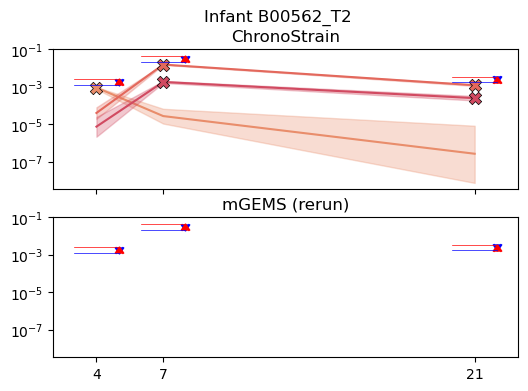

In [116]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True, sharey=True)

# infant_id = 'A00559'
# infant_id = 'B00178'
infant_id = 'B00562_T2'
# infant_id = 'B00053'
# infant_id = 'B02273'


#infant_id = 'C01331'
#infant_id = 'A01678'


axes[0].set_title('ChronoStrain')
plot_chronostrain(infant_id, 'chronostrain', axes[0], sb.color_palette("flare"), dfs_to_plot['chronostrain:coarse_default'], plot_config.chronostrain['coarse_default'].posterior)
axes[1].set_title('mGEMS (rerun)')
plot_mgems(infant_id, axes[1], sb.color_palette("crest"), dfs_to_plot['mgems:coarse'], marker_enforce_demix_ub=2)
fig.suptitle(f"Infant {infant_id}")

plot_third_party_species_estimates(infant_id, axes[0], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, axes[1], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, axes[0], metaphlan_estimates, marker_color='red', arrow_direction='up')
plot_third_party_species_estimates(infant_id, axes[1], metaphlan_estimates, marker_color='red', arrow_direction='up')
# plot_bracken_estimates(infant_id, axes[2])

for ax in axes:
    ax.set_yscale('log')
plt.savefig(f'plots/{infant_id}_traj.png')

## 3.3 bracken/metaphlan comparison

### Code

In [29]:
def plot_third_party_species_comparison_paper(chronostrain_dfs, mgems_dfs, species_estimates, ax, third_party_name='Third-Party'):
    (
        _,
        cs_clusters,
        cs_infants, 
        cs_isolates_within,
        cs_isolates_across,
        cs_results,
        cs_results_thresholded,
        cs_results_thresholded_counts,
    ) = chronostrain_dfs

    (
        _,
        ms_clusters,
        ms_infants, 
        ms_isolates_within,
        ms_isolates_across,
        ms_results,
        ms_results_thresholded,
        ms_results_thresholded_counts,
    ) = mgems_dfs

    chronostrain_efaec_estimates = cs_results.loc[
        (cs_results['Genus'] == 'Enterococcus')
        & (cs_results['Species'] == 'faecalis')
    ].groupby(['Infant', 'T'])['AbundOverall'].sum().rename('Efaec').reset_index()
    
    merged_found_across = cs_isolates_across[['CultureT', 'PredictionT', 'Infant', 'Isolate', 'Found', 'Abund', 'AbundOverall', 'Posterior']].merge(
        ms_isolates_across[['CultureT', 'PredictionT', 'Infant', 'Isolate', 'Found', 'Abund', 'AbundOverall', 'DemixCheckScore']],
        on=['CultureT', 'PredictionT', 'Infant', 'Isolate'],
        suffixes=['CS', 'MS'],
        how='outer'
    )
    merged_found_across['FoundCS'] = merged_found_across['FoundCS'].astype('boolean').fillna(False)
    merged_found_across['FoundMS'] = merged_found_across['FoundMS'].astype('boolean').fillna(False)
    
    # ... but first group by sample, to remove redundancies (we want to count each stool sample once)
    isolate_cross_grouped = merged_found_across.groupby(['Infant', 'PredictionT'])[['FoundCS', 'FoundMS']].max().reset_index()

    # For those samples, plot the fold-change from bracken predictions.
    
    cross_isol_df = pd.concat(
        [
            isolate_cross_grouped.loc[isolate_cross_grouped['FoundCS'] & ~isolate_cross_grouped['FoundMS'], ['Infant', 'PredictionT']].assign(Category='CS-only'),
            isolate_cross_grouped.loc[~isolate_cross_grouped['FoundCS'] & isolate_cross_grouped['FoundMS'], ['Infant', 'PredictionT']].assign(Category='mGEMS-only'),
            isolate_cross_grouped.loc[isolate_cross_grouped['FoundCS'] & isolate_cross_grouped['FoundMS'], ['Infant', 'PredictionT']].assign(Category='Both'),
        ],
        ignore_index=True
    ).rename(columns={'PredictionT': 'T'})
    cat_order = ['All Samples', 'Both', 'CS-only', 'mGEMS-only']

    # ============ attach the species-wide estimates.
    _x = cross_isol_df.merge(
        chronostrain_efaec_estimates, on=['Infant', 'T']
    ).merge(
        msweep_efaec_estimates, on=['Infant', 'T'], suffixes=['CS', 'MS']
    ).merge(
        species_estimates.rename(columns={'Efaec': 'EfaecThirdParty'}),
        on=['Infant', 'T'],
        how='inner'
    )
    _x = pd.concat(
        [
            _x, 
            chronostrain_efaec_estimates.merge(
                msweep_efaec_estimates, on=['Infant', 'T'], suffixes=['CS', 'MS']
            ).assign(
                Category='All Samples'
            ).merge(
                species_estimates.rename(columns={'Efaec': 'EfaecThirdParty'}), on=['Infant', 'T'],
            )
        ],
        ignore_index=False
    )
    
    # ============ compute the fold-changes.
    eps = 1e-6
    _x['CSFold'] = np.log10(_x['EfaecCS'] + eps) - np.log10(_x['EfaecThirdParty'] + eps)
    _x['MSFold'] = np.log10(_x['EfaecMS'] + eps) - np.log10(_x['EfaecThirdParty'] + eps)
    _x['CSFoldAbs'] = np.abs(_x['CSFold'])
    _x['MSFoldAbs'] = np.abs(_x['MSFold'])

    # ============ draw the plots.
    method_list = ['CSFold', 'MSFold']
    melted = pd.melt(_x, id_vars=['Infant', 'T', 'Category'], value_vars=method_list)
    colors = sb.color_palette("tab10")
    palette = {m: c for m, c in zip(method_list, colors)}
    
    sb.boxplot(
        melted,
        x='Category', hue='variable', order=cat_order, palette=palette,
        y='value',
        medianprops=dict(color='gold', linewidth=2), showfliers=False, whis=(0.025, 0.975),
        ax=ax
    )
    sb.stripplot(
        melted,
        x='Category', hue='variable', order=cat_order, palette=palette,
        y='value',
        edgecolor='black', linewidth=1.0,
        dodge=True,
        alpha=0.2,
        ax=ax
    )

    # =================== pvalue annotation
    y_max = max(_x['CSFold'].max(), _x['MSFold'].max())
    y_min = min(_x['CSFold'].min(), _x['MSFold'].min())
    annot_height = 0.2
    text_offset = 0.05
    text_height = 0.4

    cat_pvals = []
    for cat_value in cat_order:
        cat_section = _x.loc[_x['Category'] == cat_value]
        test_result = scipy.stats.mannwhitneyu(cat_section['CSFold'].to_numpy(), cat_section['MSFold'].to_numpy(), alternative='two-sided')
        print("{} fold-change p-value [{}] --> {}".format(third_party_name, cat_value, test_result))
        cat_pvals.append(test_result.pvalue)

    import statsmodels
    _, cat_pvals_bh = statsmodels.stats.multitest.fdrcorrection(cat_pvals, alpha=0.05, method='p') ## alpha doesn't matter here, we want to output raw p-values with multiple-hypothesis correction

    for cat_idx, (cat_name, cat_pval_bh) in enumerate(zip(cat_order, cat_pvals_bh)):
        x1 = cat_idx - 0.25
        x2 = cat_idx + 0.25
        y1 = y_max
        y2 = y1 + annot_height
        x_text = cat_idx
        y_text = y2 + text_offset
        if cat_pval_bh < 0.01:
            text_str = "p={:.1e}".format(cat_pval_bh)
        else:
            text_str = "p={:.2f}".format(cat_pval_bh)
        if cat_pval_bh < 0.05:
            text_color = 'red'
        else:
            text_color = 'black'
        ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], color='black', linewidth=1.0, linestyle='-')
        ax.text(x=x_text, y=y_text, s=text_str, ha='center', va='bottom', size=9.0, color=text_color)
    
    # =================== axis labels.
    #ax.text(x=1/8, y=-0.12, s='asdf', transform=ax.transAxes, horizontalalignment ='center')
    ax.text(x=(1/4) + (3/8), y=-0.16, s='[Isolates across-timepoint]', transform=ax.transAxes, horizontalalignment='center', fontweight='bold')
    ax.axvline(x=0.5, color='black', linewidth=0.5)
    ax.legend([],[], frameon=False)
    ax.set_ylim(y_min - 0.5, y_max + annot_height + text_offset + text_height + 0.2)
    ax.set_ylabel(f'10-fold change vs {third_party_name} estimate \n' + r'$\bf{(Species-level)}$')
    return palette, _x


def plot_third_party_species_comparison_supp(chronostrain_dfs, mgems_dfs, species_estimates, ax, third_party_name='Third-Party'):
    """
    Plot the raw bracken/metaphlan comparisons versus the fold-changes, to argue that fold changes tend to be larger (methods are more inaccurate) when the abundance is small.
    """
    (
        _,
        cs_clusters,
        cs_infants,
        cs_isolates_within,
        cs_isolates_across,
        cs_results,
        cs_results_thresholded,
        cs_results_thresholded_counts,
    ) = chronostrain_dfs

    (
        _,
        ms_clusters,
        ms_infants,
        ms_isolates_within,
        ms_isolates_across,
        ms_results,
        ms_results_thresholded,
        ms_results_thresholded_counts,
    ) = mgems_dfs

    chronostrain_efaec_estimates = cs_results.loc[
        (cs_results['Genus'] == 'Enterococcus')
        & (cs_results['Species'] == 'faecalis')
    ].groupby(['Infant', 'T'])['AbundOverall'].sum().rename('Efaec').reset_index()
    
    _x = chronostrain_efaec_estimates.merge(
        msweep_efaec_estimates, on=['Infant', 'T'], suffixes=['CS', 'MS']
    ).assign(
        Category='All Samples'
    ).merge(
        species_estimates.rename(columns={'Efaec': 'EfaecThirdParty'}), on=['Infant', 'T'],
        # bracken_estimates.rename(columns={'Efaec': 'EfaecThirdParty'}), on=['Infant', 'T'],
    )
    
    # ============ compute the fold-changes.
    eps = 1e-6
    _x['CSFold'] = np.log10(_x['EfaecCS'] + eps) - np.log10(_x['EfaecThirdParty'] + eps)
    _x['MSFold'] = np.log10(_x['EfaecMS'] + eps) - np.log10(_x['EfaecThirdParty'] + eps)
    _x['CSFoldAbs'] = np.abs(_x['CSFold'])
    _x['MSFoldAbs'] = np.abs(_x['MSFold'])

    ax.scatter(_x['EfaecThirdParty'], _x['CSFold'], color='tab:blue', label='ChronoStrain', alpha=0.2)
    ax.scatter(_x['EfaecThirdParty'], _x['MSFold'], color='tab:orange', label='mGEMS', alpha=0.2)
    ax.set_xlabel('Efaecalis abundance ({})'.format(third_party_name))
    ax.set_ylabel('10-Fold Change (Species-level estimate)')
    ax.legend()
    ax.set_xscale('log')

### Render

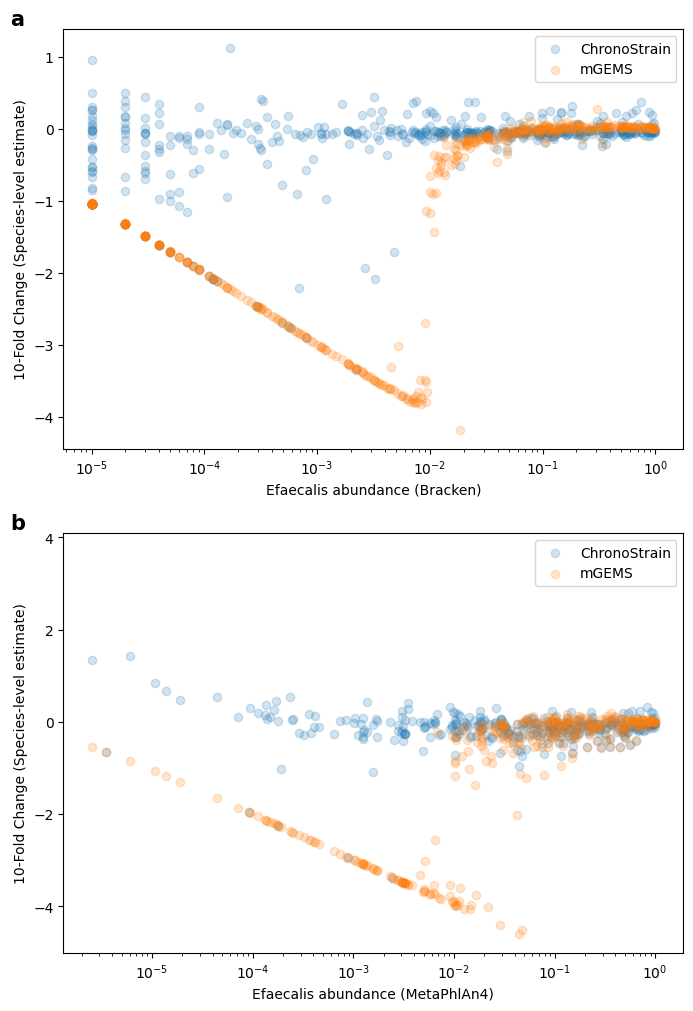

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

plot_third_party_species_comparison_supp(dfs_to_plot['chronostrain:coarse_default'], dfs_to_plot['mgems:coarse'], bracken_estimates, axes[0], third_party_name='Bracken')
plot_third_party_species_comparison_supp(dfs_to_plot['chronostrain:coarse_default'], dfs_to_plot['mgems:coarse'], metaphlan_estimates, axes[1], third_party_name='MetaPhlAn4')

add_figure_labels(
    fig, 
    axes,
   ['a', 'b'],
    x_pos=-0.03, y_pos=1.01
)
plt.savefig('plots/bracken_fold_change.pdf', bbox_inches='tight')

## 3.4 Putting it together: paper-plot

AVAILABLE KEYS: ['chronostrain:coarse_default', 'chronostrain:fine', 'chronostrain:mut_002', 'mgems:coarse', 'mgems:coarse_no_demix', 'mgems:mut_002_dm2', 'mgems:mut_002_dm3', 'mgems:mut_002_dm4']
['CP030932.1' '28157_4#329']
Isolate scatterplots will have demix_check score <= 2 enforced!
['28157_4#359' 'GCA_902160045']
Isolate scatterplots will have demix_check score <= 2 enforced!
['28099_2#148' 'GCA_902161785']
Isolate scatterplots will have demix_check score <= 2 enforced!
P-values for # clusters called:
CS vs mGEMS --> 1.721867343048659e-34
CS vs mGEMS (no QC) --> 1.9865316452010975e-20
mGEMS vs mGEMS (no QC) --> 2.2773208056849183e-40
P-values for # genomes called:
CS vs mGEMS --> 1.5504713941912865e-05
CS vs mGEMS (no QC) --> 1.6904949899193885e-16
mGEMS vs mGEMS (no QC) --> 2.6142302210486814e-40
Bracken fold-change p-value [All Samples] --> MannwhitneyuResult(statistic=153821.0, pvalue=2.9721116935043186e-18)
Bracken fold-change p-value [Both] --> MannwhitneyuResult(statistic=

,CSFold,MSFold
Category,,
All Samples,-0.052002,-0.390433
Both,-0.042348,-0.000149
CS-only,-0.046313,-2.173682
mGEMS-only,-0.044213,-0.154223


third-party fold change, ``both`` (158 samples) vs ``cs-only''  (63 samples): MannwhitneyuResult(statistic=9067.0, pvalue=7.87642287579643e-22)
done plotting.


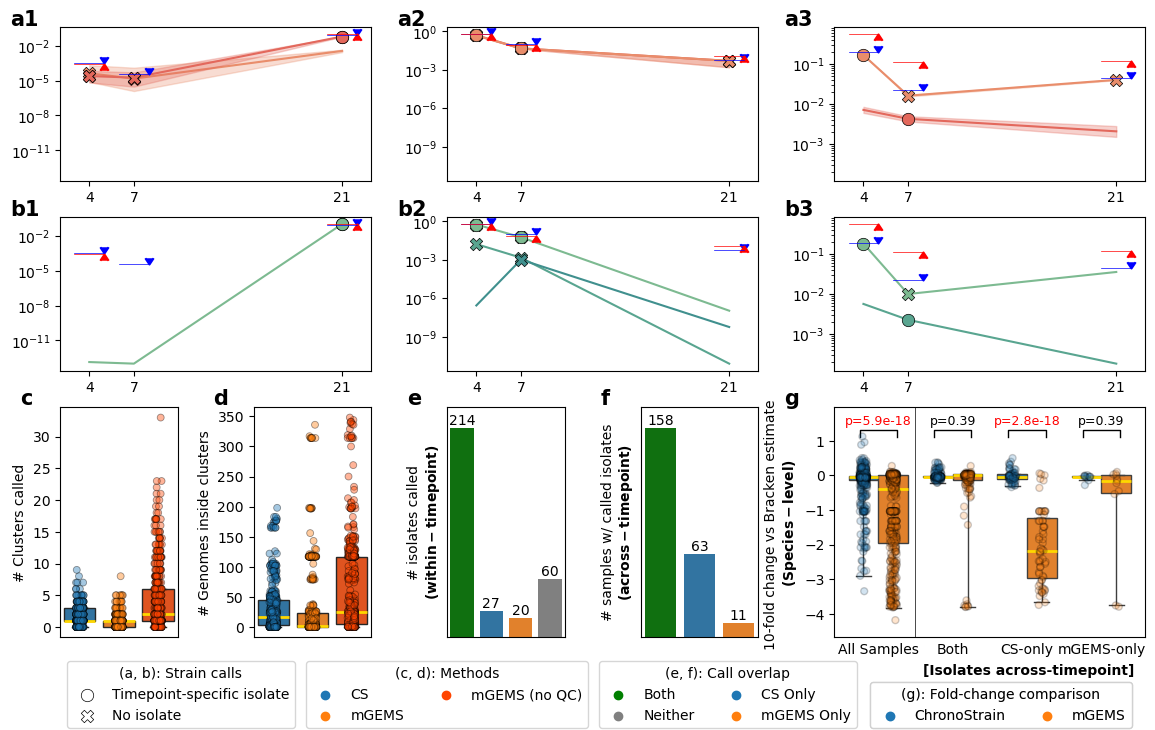

In [32]:
size_scaling = 1.0
fig = plt.figure(figsize=(14 * size_scaling, 9 * size_scaling))

gs = gridspec.GridSpec(ncols=6, nrows=4, figure=fig, height_ratios=[1, 1, 1.5, 0.3], wspace=0.65, hspace=0.25)
timeseries1 = [fig.add_subplot(gs[0, 0:2]), fig.add_subplot(gs[1, 0:2])]
timeseries1_labels = ['a1', 'b1']
timeseries2 = [fig.add_subplot(gs[0, 2:4]), fig.add_subplot(gs[1, 2:4])]
timeseries2_labels = ['a2', 'b2']
timeseries3 = [fig.add_subplot(gs[0, 4:]), fig.add_subplot(gs[1, 4:])]
timeseries3_labels = ['a3', 'b3']

bottom_row = [
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[2, 1]),
    fig.add_subplot(gs[2, 2]),
    fig.add_subplot(gs[2, 3]),
    fig.add_subplot(gs[2, 4:]),
]
bottom_labels = ['c', 'd', 'e', 'f', 'g']

legend_ax = fig.add_subplot(gs[3, :])

for ax in timeseries1 + timeseries2 + timeseries3:
    ax.set_yscale('log')
timeseries1[0].sharey(timeseries1[1])
timeseries1[0].sharex(timeseries1[1])
timeseries2[0].sharey(timeseries2[1])
timeseries2[0].sharex(timeseries2[1])
timeseries3[0].sharey(timeseries3[1])
timeseries3[0].sharex(timeseries3[1])
add_figure_labels(
    fig, 
    timeseries1 + timeseries2 + timeseries3 + bottom_row, 
    timeseries1_labels + timeseries2_labels + timeseries3_labels + bottom_labels,
    x_pos=-0.05, y_pos=1.01
)

print("AVAILABLE KEYS:", list(dfs_to_plot.keys()))
infant_id = 'A01077'
plot_chronostrain(infant_id, plot_config.chronostrain['coarse_default'].key, timeseries1[0], sb.color_palette("flare"), dfs_to_plot['chronostrain:coarse_default'], plot_config.chronostrain['coarse_default'].posterior)
plot_mgems(infant_id, timeseries1[1], sb.color_palette("crest"), dfs_to_plot['mgems:coarse'], marker_enforce_demix_ub=2)
plot_third_party_species_estimates(infant_id, timeseries1[0], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries1[1], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries1[0], metaphlan_estimates, marker_color='red', arrow_direction='up')
plot_third_party_species_estimates(infant_id, timeseries1[1], metaphlan_estimates, marker_color='red', arrow_direction='up')


infant_id = 'B00053'
plot_chronostrain(infant_id, plot_config.chronostrain['coarse_default'].key, timeseries2[0], sb.color_palette("flare"), dfs_to_plot['chronostrain:coarse_default'], plot_config.chronostrain['coarse_default'].posterior)
plot_mgems(infant_id, timeseries2[1], sb.color_palette("crest"), dfs_to_plot['mgems:coarse'], marker_enforce_demix_ub=2)
plot_third_party_species_estimates(infant_id, timeseries2[0], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries2[1], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries2[0], metaphlan_estimates, marker_color='red', arrow_direction='up')
plot_third_party_species_estimates(infant_id, timeseries2[1], metaphlan_estimates, marker_color='red', arrow_direction='up')


infant_id = 'B02273'
plot_chronostrain(infant_id, plot_config.chronostrain['coarse_default'].key, timeseries3[0], sb.color_palette("flare"), dfs_to_plot['chronostrain:coarse_default'], plot_config.chronostrain['coarse_default'].posterior)
plot_mgems(infant_id, timeseries3[1], sb.color_palette("crest"), dfs_to_plot['mgems:coarse'], marker_enforce_demix_ub=2)
plot_third_party_species_estimates(infant_id, timeseries3[0], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries3[1], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries3[0], metaphlan_estimates, marker_color='red', arrow_direction='up')
plot_third_party_species_estimates(infant_id, timeseries3[1], metaphlan_estimates, marker_color='red', arrow_direction='up')


key_order = ['chronostrain:coarse_default', 'mgems:coarse', 'mgems:coarse_no_demix']
# key_order = ['chronostrain:coarse_default', 'chronostrain:fine', 'mgems:coarse', 'mgems:coarse_no_demix']

# plot_isolates_recovered(dfs_to_plot, mutual_infants, method_names, bottom_row[0])
plot_clusters_called(dfs_to_plot, key_order, method_colors, bottom_row[0])
bottom_row[0].set_xlabel('')
bottom_row[0].set_xticks([])
plot_genomes_called(dfs_to_plot, key_order, method_colors, bottom_row[1])
bottom_row[1].set_xlabel('')
bottom_row[1].set_xticks([])
bottom_row[1].set_ylabel('# Genomes inside clusters')

barplot_colors = barplot_isolate_calls_within_sample(dfs_to_plot['chronostrain:coarse_default'], dfs_to_plot['mgems:coarse'], bottom_row[2])
barplot_isolate_calls_across_sample(dfs_to_plot['chronostrain:coarse_default'], dfs_to_plot['mgems:coarse'], bottom_row[3])
bottom_row[2].set_xticks([])
bottom_row[3].set_xticks([])
# barplot_isolate_calls_across_sample(dfs_to_plot['chronostrain:coarse'], dfs_to_plot['mgems:coarse'], bottom_row[3])


third_party_comparison_colors, plotted_df = plot_third_party_species_comparison_paper(dfs_to_plot['chronostrain:coarse_default'], dfs_to_plot['mgems:coarse'], bracken_estimates, bottom_row[4], third_party_name='Bracken')
bottom_row[4].set_xlabel('')
bottom_row[4].tick_params('x', length=0, width=1, which='major')

# =====  Medians
display(plotted_df.groupby("Category")[['CSFold', 'MSFold']].median())

# ===== mGEMS pvalue ("does mGEMS significantly underestimate isolates in non-matching timepoints vs matching?")
_x = plotted_df.loc[(plotted_df['Category'] == 'Both'), 'MSFold'].to_numpy()
_y = plotted_df.loc[(plotted_df['Category'] == 'CS-only'), 'MSFold'].to_numpy()
print("third-party fold change, ``both`` ({} samples) vs ``cs-only''  ({} samples): {}".format(
    len(_x),
    len(_y),
    scipy.stats.mannwhitneyu(_x, _y, alternative='greater')
))

# ===== legends
legends = []
handles, labels = zip(*[
    (legend_ax.scatter([], [], color='white', marker='o', s=80, edgecolors='black', linewidth=0.5), 'Timepoint-specific isolate'),
    (legend_ax.scatter([], [], color='white', marker='X', s=80, edgecolors='black', linewidth=0.5), 'No isolate')
])
legends.append(legend_ax.legend(
    handles, labels, title="(a, b): Strain calls", bbox_to_anchor=(0.00, -0.33), loc="lower left", ncols=1,
))

method_order = [dfs_to_plot[k][0] for k in key_order]
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_colors[m]), m) 
    for m in method_order
])
legends.append(legend_ax.legend(
    handles, labels, title="(c, d): Methods", bbox_to_anchor=(0.22, -0.33), loc="lower left", ncols=2,
))


handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=barplot_colors[m]), m) 
    for m in ['Both', 'Neither', 'CS Only', 'mGEMS Only']
])
legends.append(legend_ax.legend(
    handles, labels, title="(e, f): Call overlap", bbox_to_anchor=(0.49, -0.33), loc="lower left", ncols=2,
))


handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=third_party_comparison_colors[m]), display_txt) 
    for m, display_txt in zip(['CSFold', 'MSFold'], ['ChronoStrain', 'mGEMS'])
])
legends.append(legend_ax.legend(
    handles, labels, title="(g): Fold-change comparison", bbox_to_anchor=(0.74, -0.33), loc="lower left", ncols=2
))

for l in legends:
    legend_ax.add_artist(l)
legend_ax.axis('off')

plt.savefig("plots/infant_paper_plot.pdf", bbox_inches='tight')
print("done plotting.")

## Fine-grained analysis

AVAILABLE KEYS: ['chronostrain:coarse_default', 'chronostrain:fine', 'chronostrain:mut_002', 'mgems:coarse', 'mgems:coarse_no_demix', 'mgems:mut_002_dm2', 'mgems:mut_002_dm3', 'mgems:mut_002_dm4']
mutual infants: {'C01560', 'C01917', 'C02186', 'B00922', 'C02016', 'B00101', 'C01751', 'B00136', 'B00236', 'A01105', 'B00092', 'A01586', 'B00076', 'B00203_T1', 'A01011', 'B00088', 'C01832', 'B02270', 'B00174', 'A01563', 'B02156', 'A01921', 'B02257', 'B00111', 'B00012', 'C01008_T2', 'C01837', 'C02695', 'C02047', 'B00027', 'B00268', 'A00021_T2', 'A00031', 'B00020', 'B00562_T2', 'B00085', 'C01844', 'B00036', 'A01166', 'B00157_T3', 'B01339', 'B00090', 'C01392', 'C01010', 'B00272', 'B00129', 'A00219', 'A01077', 'C02391', 'B01375', 'B01042', 'A01966', 'B00203_T2', 'A01678', 'B00537', 'B00116', 'C01201', 'B01278', 'B01719', 'C01841', 'C01839', 'A01802', 'A01866', 'A01057', 'A00067', 'A01301', 'B02216', 'C01075', 'A01639', 'C01529', 'B02315', 'B02326', 'A01506', 'B01365', 'B00235', 'B02211', 'B01716'

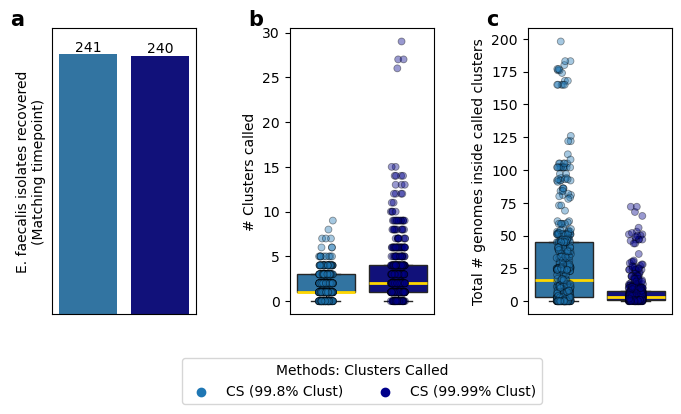

In [33]:
size_scaling = 1.6
fig = plt.figure(figsize=(5 * size_scaling, 3 * size_scaling))

gs = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, height_ratios=[2, 0.3], wspace=0.65, hspace=0.25)

axis_row = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2])
]
axis_labels = ['a', 'b', 'c']

legend_axes = [fig.add_subplot(gs[-1, :])]

add_figure_labels(
    fig, 
    axis_row, axis_labels,
    x_pos=-0.05, y_pos=1.01
)

print("AVAILABLE KEYS:", list(dfs_to_plot.keys()))


# key_order = ['chronostrain:coarse_default', 'mgems:coarse', 'mgems:coarse_no_demix']
key_order = ['chronostrain:coarse_default', 'chronostrain:fine']
# method_colors = {
#     'CS': 'tab:blue',
#     'CS (99.99% Clust)': 'darkblue',
#     'mGEMS': 'tab:orange',
#     'mGEMS (no QC)': 'orangered'
# }

# plot_isolates_recovered(dfs_to_plot, mutual_infants, method_names, bottom_row[0])
plot_isolates_recovered(dfs_to_plot, key_order, method_colors, axis_row[0])
plot_clusters_called(dfs_to_plot, key_order, method_colors, axis_row[1])
plot_genomes_called(dfs_to_plot, key_order, method_colors, axis_row[2])
for ax in axis_row:
    ax.set_xlabel('')
    ax.set_xticks([])


# ===== legends
method_order = [dfs_to_plot[k][0] for k in key_order]
method_display_names = ['CS (99.8% Clust)', 'CS (99.99% Clust)']
handles, labels = zip(*[
    (legend_axes[0].scatter([], [], facecolors=method_colors[m]), m_name) 
    for m, m_name in zip(method_order, method_display_names)
])
method_legend = legend_axes[0].legend(
    handles, labels, title="Methods: Clusters Called", bbox_to_anchor=(0.5, -0.3), loc="lower center", ncols=2,
)
legend_axes[0].axis('off')


for key in key_order:
    method_name, _, method_infants, _, _, _, _, thres_res_counts = dfs_to_plot[key]
    # display(thres_res_counts[['NumClusters', 'TotalMembers']].describe())


plt.savefig("plots/infant_paper_plot_99_99pct.pdf", bbox_inches='tight')
print("done plotting.")

## Mutated database analysis

### plotting helper

In [34]:
def calculate_bar_x(n_bars: int, bar_width: float, x: float):
    total_bars = n_bars * bar_width
    x0 = x - (total_bars / 2)
    return [
        x0 + i * (bar_width)
        for i in range(n_bars)
    ]


def plot_dual_counts(counts_all, counts_filt, x_key: str, hue_key: str, y_key: str, x_order: List, hue_order: List, x_labels: List, palette: Dict, ax):
    # All counts
    for x_coord, x_value in enumerate(x_order):
        bar_width = 0.9 / len(hue_order)
        bar_x_locs = calculate_bar_x(n_bars=len(hue_order), bar_width=bar_width, x=x_coord)
        heights = [counts_all.loc[(hue_value, x_value)] for hue_value in hue_order]
        container = ax.bar(x=bar_x_locs, height=heights, width=bar_width, bottom=0.0, align='edge', color=[palette[h] for h in hue_order], zorder=-1)
        bar_labels = [str(h) for h in heights]
        ax.bar_label(container, labels=bar_labels, label_type='edge')
    ax.set_ylim(0, counts_all.max() * 1.1)

    # Filt counts only
    for x_coord, x_value in enumerate(x_order):
        bar_width = 0.9 / len(hue_order)
        bar_x_locs = calculate_bar_x(n_bars=len(hue_order), bar_width=bar_width, x=x_coord)
        heights = [counts_filt.loc[(hue_value, x_value)] for hue_value in hue_order]
        container = ax.bar(x=bar_x_locs, height=heights, width=bar_width, bottom=0.0, align='edge', color='white', alpha=0.5, zorder=1)
        bar_labels = [
            str(h) if h > 4 else ''
            for h in heights
        ]
        for bar in container.patches:
            bar.set_hatch("///")
        ax.bar_label(container, labels=bar_labels, label_type='center', path_effects=[pe.withStroke(linewidth=3, foreground="white")])

    # Non-filt counts only
    counts_nonfilt = counts_all - counts_filt
    for x_coord, x_value in enumerate(x_order):
        bar_width = 0.9 / len(hue_order)
        bar_x_locs = calculate_bar_x(n_bars=len(hue_order), bar_width=bar_width, x=x_coord)
        heights = [counts_nonfilt.loc[(hue_value, x_value)] for hue_value in hue_order]
        bottoms = [counts_filt.loc[(hue_value, x_value)] for hue_value in hue_order]
        container = ax.bar(x=bar_x_locs, height=heights, width=bar_width, bottom=bottoms, align='edge', color=[palette[h] for h in hue_order], zorder=1)
        bar_labels = [
            str(h) if h > 4 else ''
            for h in heights
        ]
        ax.bar_label(container, labels=bar_labels, label_type='center', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
    
    
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticks([])
    ax.set_ylabel('Count')

In [35]:
def plot_demix_check_distribution(dfs_to_plot, mgems_keys: List[str], ax, abund_lb: float):
    """ Plot the results' demix_check scores for the target clusters containing isolates. Each datapoint is 1 unique triple (cluster, infant_id, sample). """
    df_sections = []
    isolate_subset = set(efaecalis_isolate_df['Accession'])
    mutual_infants = set(all_infant_ids)
    for mgems_key in mgems_keys:
        (
            method_name,
            ms_clusters,
            ms_infants,
            ms_isolates_within,
            ms_isolates_across,
            ms_results,
            ms_results_thresholded,
            ms_results_thresholded_counts,
        ) = dfs_to_plot[mgems_key]
        mutual_infants = mutual_infants.intersection(ms_infants)
        mutual_isolate_subset = isolate_subset.intersection(
            set(ms_clusters['Accession'])
        )

    method_names = []
    for mgems_key in mgems_keys:
        (
            method_name,
            ms_clusters,
            ms_infants,
            ms_isolates_within,
            ms_isolates_across,
            ms_results,
            ms_results_thresholded,
            ms_results_thresholded_counts,
        ) = dfs_to_plot[mgems_key]
        method_names.append(method_name)

        for infant_id in mutual_infants:
            isolate_section = efaecalis_isolate_df.loc[(efaecalis_isolate_df['Infant'] == infant_id) & efaecalis_isolate_df['Accession'].isin(mutual_isolate_subset)]
            if isolate_section.shape[0] == 0:
                continue
            target_clusters = ms_clusters.merge(isolate_section, on=['Accession'], how='inner')
            result_section = ms_results.merge(
                target_clusters,
                on=['Infant', 'T', 'Cluster']
            )
            df_sections.append(
                result_section[
                    ['Infant', 'T', 'Cluster', 'Abund', 'DemixCheckScore']
                ].assign(Method=method_name)
            )
        
    df_concat = pd.concat(df_sections, ignore_index=True)
    
    demix_order = [1, 2, 3, 4]

    # ========== abund thresholded counts
    counts_filt = df_concat.loc[
        df_concat['Abund'] <= abund_lb,
        :
    ].groupby(['Method', 'DemixCheckScore'])['Cluster'].count().rename('ScoreCount')
    
    # fill in zeros
    for method, d_score in itertools.product(method_names, demix_order):
        try:
            _ = counts_filt.loc[(method, d_score)]
        except KeyError:
            counts_filt.loc[(method, d_score)] = 0

    # ======== full counts
    counts_all = df_concat.groupby(['Method', 'DemixCheckScore'])['Cluster'].count().rename('ScoreCount')

    # fill in zeros
    for method, d_score in itertools.product(method_names, demix_order):
        try:
            _ = counts_all.loc[(method, d_score)]
        except KeyError:
            counts_all.loc[(method, d_score)] = 0
    demix_labels = ['1', '2', '3', '4']
    plot_dual_counts(
        counts_all, 
        counts_filt, 
        x_key='DemixCheckScore',
        hue_key='Method', 
        y_key='ScoreCount', 
        x_order=demix_order, 
        hue_order=method_names, 
        x_labels=demix_labels,
        palette=method_colors,
        ax=ax
    )
    ax.set_xlabel("mGEMS demix_check score")
    
    return df_concat

In [36]:
def plot_chronostrain_posterior_distribution(dfs_to_plot, chronostrain_keys: List[str], ax, abund_lb):
    """ Plot the results' demix_check scores for the target clusters containing isolates. Each datapoint is 1 unique triple (cluster, infant_id, sample). """
    df_sections = []
    isolate_subset = set(efaecalis_isolate_df['Accession'])
    mutual_infants = set(all_infant_ids)
    for chronostrain_key in chronostrain_keys:
        (
            method_name,
            cs_clusters,
            cs_infants,
            cs_isolates_within,
            cs_isolates_across,
            cs_results,
            cs_results_thresholded,
            cs_results_thresholded_counts,
        ) = dfs_to_plot[chronostrain_key]
        mutual_infants = mutual_infants.intersection(cs_infants)
        mutual_isolate_subset = isolate_subset.intersection(
            set(cs_clusters['Accession'])
        )

    method_names = []
    for chronostrain_key in chronostrain_keys:
        (
            method_name,
            cs_clusters,
            cs_infants,
            cs_isolates_within,
            cs_isolates_across,
            cs_results,
            cs_results_thresholded,
            cs_results_thresholded_counts,
        ) = dfs_to_plot[chronostrain_key]
        method_names.append(method_name)

        for infant_id in mutual_infants:
            isolate_section = efaecalis_isolate_df.loc[(efaecalis_isolate_df['Infant'] == infant_id) & efaecalis_isolate_df['Accession'].isin(mutual_isolate_subset)]
            if isolate_section.shape[0] == 0:
                continue
            target_clusters = cs_clusters.merge(isolate_section, on=['Accession'], how='inner')
            result_section = cs_results.merge(
                target_clusters,
                on=['Infant', 'T', 'Cluster']
            )
            df_sections.append(
                result_section[
                    ['Infant', 'T', 'Cluster', 'Posterior', 'Abund']
                ].assign(Method=method_name)
            )
    df_concat = pd.concat(df_sections, ignore_index=True)
    # display(df_concat.groupby("Method")['Cluster'].count())
    df_concat['PosteriorQuantile'] = pd.cut(df_concat['Posterior'], bins=[0., 0.95, 0.975, 0.985, 0.995, 1.0])
    x_order = sorted(pd.unique(df_concat['PosteriorQuantile']))[::-1]

    def interval_fmt(b):
        if b.closed == 'right':
            return f'({b.left},\n{b.right}]'
        else:
            return f'[{b.left},\n{b.right})'
    x_labels = [
        interval_fmt(interval) for interval in x_order
    ]

    # ========== abund thresholded counts
    counts_filt = df_concat.loc[
        df_concat['Abund'] <= abund_lb,
        :
    ].groupby(['Method', 'PosteriorQuantile'], observed=False)['Cluster'].count().rename('PosteriorBinnedCount')
    
    # fill in zeros
    for method, p_interval in itertools.product(method_names, x_order):
        try:
            _ = counts_filt.loc[(method, p_interval)]
        except KeyError:
            counts_filt.loc[(method, p_interval)] = 0

    # ======= full counts
    counts_all = df_concat.groupby(['Method', 'PosteriorQuantile'], observed=False)['Cluster'].count().rename('PosteriorBinnedCount')

    # fill in zeros
    for method, p_interval in itertools.product(method_names, x_order):
        try:
            _ = counts_all.loc[(method, p_interval)]
        except KeyError:
            counts_all.loc[(method, p_interval)] = 0

    
    plot_dual_counts(
        counts_all, 
        counts_filt, 
        x_key='PosteriorQuantile',
        hue_key='Method', 
        y_key='PosteriorBinnedCount', 
        x_order=x_order, 
        hue_order=method_names, 
        x_labels=x_labels,
        palette=method_colors,
        ax=ax
    )
    ax.set_xlabel("ChronoStrain posterior")

### render

In [37]:
# print out isolates that mgems:coarse successfully recovered, but restrict to lexicographically first ones for each infant.
_x = dfs_to_plot['mgems:coarse'][3]
isolate_target_subset = set(
    _x.loc[
        _x['Found']
    ].groupby("Infant")['Isolate'].head(1)
)
print(isolate_target_subset)
print(len(isolate_target_subset))

{'GCA_902163505', 'GCA_902158995', 'GCA_902158935', 'GCA_902163815', 'GCA_902162935', 'GCA_902162035', 'GCA_902159985', 'GCA_902159935', 'GCA_902161375', 'GCA_902158765', 'GCA_902166365', 'GCA_902163175', 'GCA_902166645', 'GCA_902163115', 'GCA_902164645', 'GCA_902164345', 'GCA_902164785', 'GCA_902162335', 'GCA_902158985', 'GCA_902160005', 'GCA_902161795', 'GCA_902163825', 'GCA_902160165', 'GCA_902159565', 'GCA_902163615', 'GCA_902162795', 'GCA_902163805', 'GCA_902162275', 'GCA_902158895', 'GCA_902162955', 'GCA_902163635', 'GCA_902158825', 'GCA_902160505', 'GCA_902163025', 'GCA_902162985', 'GCA_902159145', 'GCA_902158905', 'GCA_902159175', 'GCA_902161645', 'GCA_902158945', 'GCA_902165295', 'GCA_902160235', 'GCA_902163575', 'GCA_902165505', 'GCA_902162945', 'GCA_902161895', 'GCA_902164115', 'GCA_902164125', 'GCA_902161145', 'GCA_902159995', 'GCA_902161275', 'GCA_902159705', 'GCA_902161045', 'GCA_902165735', 'GCA_902163845', 'GCA_902158925', 'GCA_902161745', 'GCA_902164775', 'GCA_90215925

mutual infants: {'C01560', 'C01917', 'C02186', 'B00922', 'C02016', 'B00101', 'C01751', 'B00136', 'B00236', 'A01105', 'B00092', 'A01586', 'A01011', 'B00076', 'B00203_T1', 'B00088', 'C01832', 'B02270', 'A01563', 'B00174', 'B02156', 'A01921', 'B02257', 'B00111', 'B00012', 'C01008_T2', 'C01837', 'C02047', 'C02695', 'B00027', 'B00268', 'A00021_T2', 'A00031', 'B00020', 'B00085', 'B00562_T2', 'A01166', 'B00036', 'C01844', 'B00157_T3', 'B01339', 'B00090', 'B00129', 'B00272', 'C01010', 'C01392', 'A00219', 'A01077', 'B01375', 'C02391', 'B01042', 'A01966', 'B00203_T2', 'A01678', 'B00537', 'B00116', 'C01201', 'B01278', 'B01719', 'C01841', 'C01839', 'A01802', 'A01866', 'A00067', 'A01057', 'B02216', 'C01075', 'A01639', 'B02315', 'B02326', 'C01529', 'A01506', 'B01365', 'B00235', 'B02211', 'B01716', 'A02053', 'B01956', 'C01700', 'A00185', 'B00016', 'C01329', 'C01929', 'C01443', 'B00178', 'C01530', 'B02588', 'B02722', 'A01687', 'A01862', 'A00021_T1', 'C02059', 'C02223_T1', 'A00947', 'B00046', 'B00252',

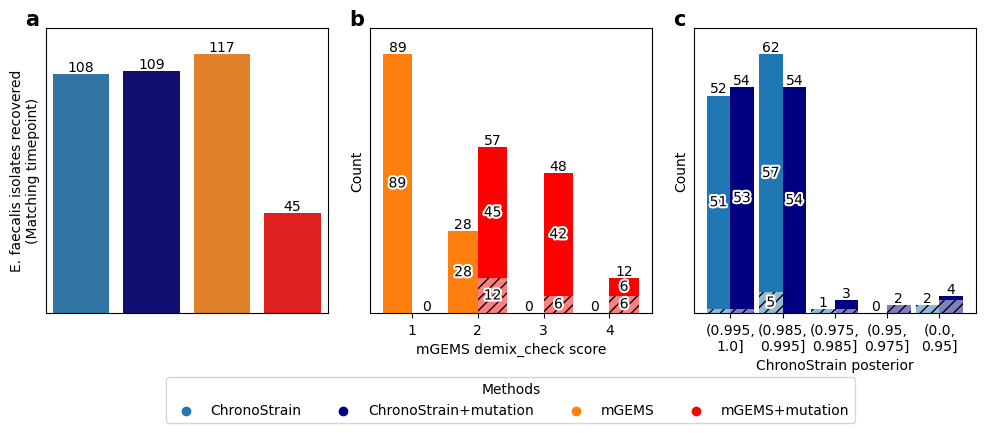

In [38]:
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, height_ratios=[5, 1], wspace=0.15, hspace=0.25)
# timeseries1 = [fig.add_subplot(gs[0, 0:2]), fig.add_subplot(gs[1, 0:2])]
# fig, axes = plt.subplots(1, 3, figsize=(12, 5), gridspec_kw=dict(width_ratios=[1, 2, 2]))

plot_axes = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])
]
plot_isolates_recovered(dfs_to_plot, ['chronostrain:coarse_default', 'chronostrain:mut_002', 'mgems:coarse', 'mgems:mut_002_dm2'], method_colors, plot_axes[0], isolate_subset=isolate_target_subset)
demix_check_df = plot_demix_check_distribution(dfs_to_plot, ['mgems:coarse', 'mgems:mut_002_dm4'], plot_axes[1], abund_lb=0.01)
plot_chronostrain_posterior_distribution(dfs_to_plot, ['chronostrain:coarse_default', 'chronostrain:mut_002'], plot_axes[2], abund_lb=0.065)
plot_axes[0].set_xticks([])
# plot_axes[1].get_legend().set_visible(False)
# plot_axes[2].get_legend().set_visible(False)


legend_ax = fig.add_subplot(gs[1, :])
handles = []
labels = ['ChronoStrain', 'ChronoStrain+mutation', 'mGEMS', 'mGEMS+mutation']
for key in ['chronostrain:coarse_default', 'chronostrain:mut_002', 'mgems:coarse', 'mgems:mut_002_dm2']:
    m_name = dfs_to_plot[key][0]
    handles.append(legend_ax.scatter([], [], facecolors=method_colors[m_name]))
method_legend = legend_ax.legend(
    handles, labels, title="Methods", bbox_to_anchor=(0.5, -0.3), loc="lower center", ncols=4
)
legend_ax.axis('off')

add_figure_labels(fig, plot_axes, 'abc', x_pos=0.05, y_pos=1.01)

plt.savefig("plots/infant_mutation_result.pdf", bbox_inches='tight')
print("done plotting.")

In [39]:
for _, row in demix_check_df.loc[demix_check_df['DemixCheckScore'] == 5].iterrows():
    infant = row['Infant']
    t = row['T']
    dataset_df = pd.read_csv(f"/data/cctm/youn/infant_nt/{infant}/dataset.tsv", sep='\t')
    res = dataset_df.loc[dataset_df['T'] == t].head(1)
    display(row.to_frame())
    sample_id = res['SampleId'].item()
    print(f"rm /data/cctm/youn/infant_nt/{infant}/mgems/mgems.mut_002.DONE")
    # print(f"rm /data/cctm/youn/infant_nt/{infant}/mgems/{sample_id}/mgems.efaecalis_mirror.mutation_002.DONE")
    # print(f"bash mutations/mgems_quantify_efaecalis_chronostrain_mutation.sh {infant} {sample_id} 002")

P-values for # clusters called:
CS[mut]
0.002 vs mGEMS[mut],0.002,demix<=2 --> 0.8721692317191021
P-values for # genomes called:
CS[mut]
0.002 vs mGEMS[mut],0.002,demix<=2 --> 5.992032782772702e-09
P-values for # clusters called:
CS[mut]
0.002 vs mGEMS[mut],0.002,demix<=3 --> 1.634741777228828e-06
P-values for # genomes called:
CS[mut]
0.002 vs mGEMS[mut],0.002,demix<=3 --> 8.2951614384491e-16
P-values for # clusters called:
CS[mut]
0.002 vs mGEMS[mut],0.002,demix<=4 --> 2.5668280977199916e-60
P-values for # genomes called:
CS[mut]
0.002 vs mGEMS[mut],0.002,demix<=4 --> 7.086269218198673e-60
done plotting.


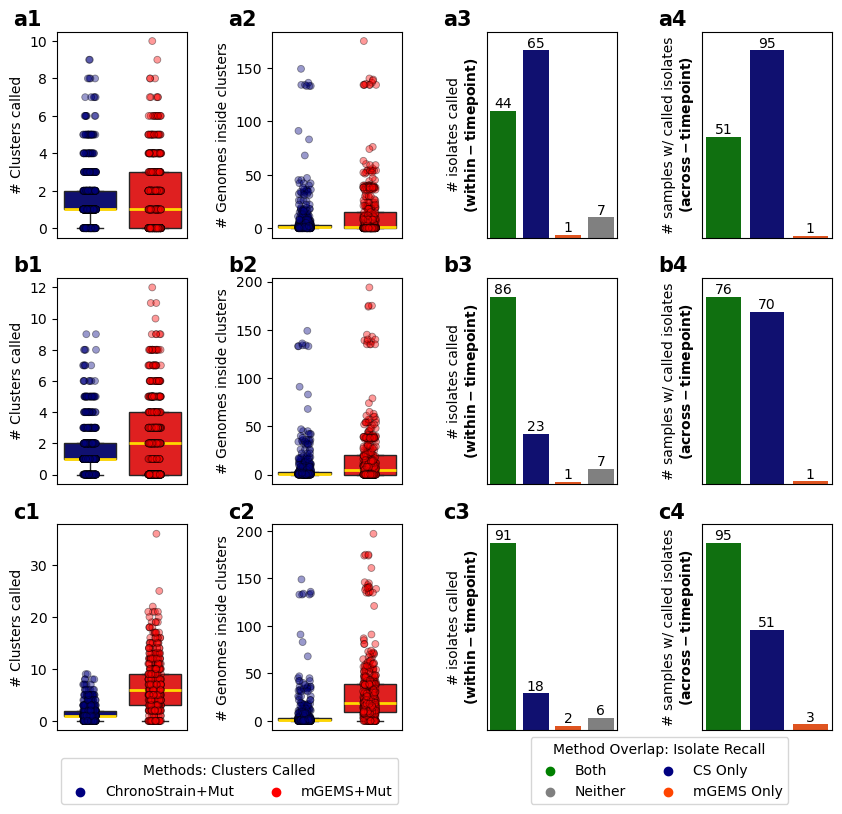

In [40]:
size_scaling = 1.0
fig = plt.figure(figsize=(10 * size_scaling, 10 * size_scaling))

gs = gridspec.GridSpec(ncols=4, nrows=4, figure=fig, height_ratios=[2, 2, 2, 0.3], wspace=0.65, hspace=0.25)

bottom_row1 = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[0, 3]),
]
bottom_labels1 = ['a1', 'a2', 'a3', 'a4']

bottom_row2 = [
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[1, 2]),
    fig.add_subplot(gs[1, 3]),
]
bottom_labels2 = ['b1', 'b2', 'b3', 'b4']

bottom_row3 = [
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[2, 1]),
    fig.add_subplot(gs[2, 2]),
    fig.add_subplot(gs[2, 3]),
]
bottom_labels3 = ['c1', 'c2', 'c3', 'c4']



legend_axes = [fig.add_subplot(gs[-1, :2]), fig.add_subplot(gs[-1, 2:])]

for ax in timeseries1 + timeseries2 + timeseries3:
    ax.set_yscale('log')
timeseries1[0].sharey(timeseries1[1])
timeseries1[0].sharex(timeseries1[1])
timeseries2[0].sharey(timeseries2[1])
timeseries2[0].sharex(timeseries2[1])
timeseries3[0].sharey(timeseries3[1])
timeseries3[0].sharex(timeseries3[1])
add_figure_labels(
    fig, 
    bottom_row1 + bottom_row2 + bottom_row3,
    bottom_labels1 + bottom_labels2 + bottom_labels3,
    x_pos=-0.07, y_pos=1.03
)

# ==== demix check score <= 2
key_order = ['chronostrain:mut_002', 'mgems:mut_002_dm2']

plot_clusters_called(dfs_to_plot, key_order, method_colors, bottom_row1[0])
bottom_row1[0].set_xlabel('')
bottom_row1[0].set_xticks([])
plot_genomes_called(dfs_to_plot, key_order, method_colors, bottom_row1[1])
bottom_row1[1].set_xlabel('')
bottom_row1[1].set_xticks([])
bottom_row1[1].set_ylabel('# Genomes inside clusters')

barplot_colors = barplot_isolate_calls_within_sample(dfs_to_plot['chronostrain:mut_002'], dfs_to_plot['mgems:mut_002_dm2'], bottom_row1[2], cs_color='navy', ms_color='orangered')
barplot_isolate_calls_across_sample(dfs_to_plot['chronostrain:mut_002'], dfs_to_plot['mgems:mut_002_dm2'], bottom_row1[3], cs_color='navy', ms_color='orangered')
bottom_row1[2].set_xticks([])
bottom_row1[3].set_xticks([])

# ==== demix check score <= 3
key_order = ['chronostrain:mut_002', 'mgems:mut_002_dm3']

plot_clusters_called(dfs_to_plot, key_order, method_colors, bottom_row2[0])
bottom_row2[0].set_xlabel('')
bottom_row2[0].set_xticks([])
plot_genomes_called(dfs_to_plot, key_order, method_colors, bottom_row2[1])
bottom_row2[1].set_xlabel('')
bottom_row2[1].set_xticks([])
bottom_row2[1].set_ylabel('# Genomes inside clusters')

barplot_colors = barplot_isolate_calls_within_sample(dfs_to_plot['chronostrain:mut_002'], dfs_to_plot['mgems:mut_002_dm3'], bottom_row2[2], cs_color='navy', ms_color='orangered')
barplot_isolate_calls_across_sample(dfs_to_plot['chronostrain:mut_002'], dfs_to_plot['mgems:mut_002_dm3'], bottom_row2[3], cs_color='navy', ms_color='orangered')
bottom_row2[2].set_xticks([])
bottom_row2[3].set_xticks([])

# ==== demix check score <= 4
key_order = ['chronostrain:mut_002', 'mgems:mut_002_dm4']

plot_clusters_called(dfs_to_plot, key_order, method_colors, bottom_row3[0])
bottom_row3[0].set_xlabel('')
bottom_row3[0].set_xticks([])
plot_genomes_called(dfs_to_plot, key_order, method_colors, bottom_row3[1])
bottom_row3[1].set_xlabel('')
bottom_row3[1].set_xticks([])
bottom_row3[1].set_ylabel('# Genomes inside clusters')

barplot_colors = barplot_isolate_calls_within_sample(dfs_to_plot['chronostrain:mut_002'], dfs_to_plot['mgems:mut_002_dm4'], bottom_row3[2], cs_color='navy', ms_color='orangered')
barplot_isolate_calls_across_sample(dfs_to_plot['chronostrain:mut_002'], dfs_to_plot['mgems:mut_002_dm4'], bottom_row3[3], cs_color='navy', ms_color='orangered')
bottom_row3[2].set_xticks([])
bottom_row3[3].set_xticks([])


# ===== legends
key_order = ['chronostrain:mut_002', 'mgems:mut_002_dm2']
method_order = [dfs_to_plot[k][0] for k in key_order]
method_legend_labels = ['ChronoStrain+Mut', r'mGEMS+Mut']

handles, labels = zip(*[
    (legend_axes[0].scatter([], [], facecolors=method_colors[m]), m_txt) 
    for m, m_txt in zip(method_order, method_legend_labels)
])
method_legend = legend_axes[0].legend(
    handles, labels, title="Methods: Clusters Called", bbox_to_anchor=(0.5, -0.3), loc="lower center", ncols=2,
)
legend_axes[0].axis('off')


handles, labels = zip(*[
    (legend_axes[1].scatter([], [], facecolors=barplot_colors[m]), m) 
    for m in ['Both', 'Neither', 'CS Only', 'mGEMS Only']
])
method_legend = legend_axes[1].legend(
    handles, labels, title="Method Overlap: Isolate Recall", bbox_to_anchor=(0.5, -0.3), loc="lower center", ncols=2,
)
legend_axes[1].axis('off')


plt.savefig("plots/infant_mutation_output_counts.pdf", bbox_inches='tight')
print("done plotting.")

AVAILABLE KEYS: ['chronostrain:coarse_default', 'chronostrain:fine', 'chronostrain:mut_002', 'mgems:coarse', 'mgems:coarse_no_demix', 'mgems:mut_002_dm2', 'mgems:mut_002_dm3', 'mgems:mut_002_dm4']
['29594_2#67' '28099_2#180' 'GCA_902159705' '26975_2#183' 'CP030932.1']
Isolate scatterplots will have demix_check score <= 2 enforced!
['GCA_902158895' 'GCA_902159935']
Isolate scatterplots will have demix_check score <= 2 enforced!
['28099_2#148' 'GCA_902161785']
Isolate scatterplots will have demix_check score <= 2 enforced!
done plotting.


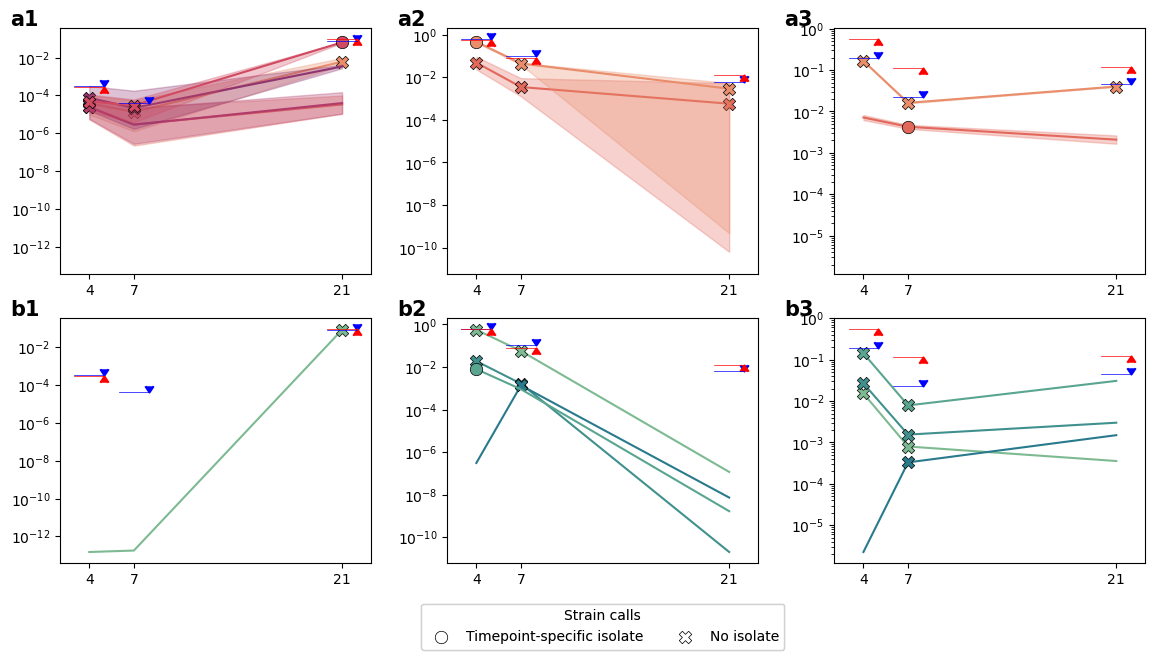

In [41]:
size_scaling = 1.0
fig = plt.figure(figsize=(14 * size_scaling, 8 * size_scaling))

gs = gridspec.GridSpec(ncols=6, nrows=3, figure=fig, height_ratios=[1, 1, 0.15], wspace=0.65, hspace=0.25)
timeseries1 = [fig.add_subplot(gs[0, 0:2]), fig.add_subplot(gs[1, 0:2])]
timeseries1_labels = ['a1', 'b1']
timeseries2 = [fig.add_subplot(gs[0, 2:4]), fig.add_subplot(gs[1, 2:4])]
timeseries2_labels = ['a2', 'b2']
timeseries3 = [fig.add_subplot(gs[0, 4:]), fig.add_subplot(gs[1, 4:])]
timeseries3_labels = ['a3', 'b3']

for ax in timeseries1 + timeseries2 + timeseries3:
    ax.set_yscale('log')
timeseries1[0].sharey(timeseries1[1])
timeseries1[0].sharex(timeseries1[1])
timeseries2[0].sharey(timeseries2[1])
timeseries2[0].sharex(timeseries2[1])
timeseries3[0].sharey(timeseries3[1])
timeseries3[0].sharex(timeseries3[1])
add_figure_labels(
    fig, 
    timeseries1 + timeseries2 + timeseries3, 
    timeseries1_labels + timeseries2_labels + timeseries3_labels,
    x_pos=-0.05, y_pos=1.01
)

legend_ax = fig.add_subplot(gs[-1, :])

print("AVAILABLE KEYS:", list(dfs_to_plot.keys()))
infant_id = 'A01077'
plot_chronostrain(infant_id, plot_config.chronostrain['mut_002'].key, timeseries1[0], sb.color_palette("flare"), dfs_to_plot['chronostrain:mut_002'], plot_config.chronostrain['mut_002'].posterior)
plot_mgems(infant_id, timeseries1[1], sb.color_palette("crest"), dfs_to_plot['mgems:mut_002_dm2'], marker_enforce_demix_ub=2)
plot_third_party_species_estimates(infant_id, timeseries1[0], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries1[1], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries1[0], metaphlan_estimates, marker_color='red', arrow_direction='up')
plot_third_party_species_estimates(infant_id, timeseries1[1], metaphlan_estimates, marker_color='red', arrow_direction='up')


infant_id = 'B00053'
plot_chronostrain(infant_id, plot_config.chronostrain['mut_002'].key, timeseries2[0], sb.color_palette("flare"), dfs_to_plot['chronostrain:mut_002'], plot_config.chronostrain['mut_002'].posterior)
plot_mgems(infant_id, timeseries2[1], sb.color_palette("crest"), dfs_to_plot['mgems:mut_002_dm2'], marker_enforce_demix_ub=2)
plot_third_party_species_estimates(infant_id, timeseries2[0], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries2[1], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries2[0], metaphlan_estimates, marker_color='red', arrow_direction='up')
plot_third_party_species_estimates(infant_id, timeseries2[1], metaphlan_estimates, marker_color='red', arrow_direction='up')


infant_id = 'B02273'
plot_chronostrain(infant_id, plot_config.chronostrain['mut_002'].key, timeseries3[0], sb.color_palette("flare"), dfs_to_plot['chronostrain:mut_002'], plot_config.chronostrain['mut_002'].posterior)
plot_mgems(infant_id, timeseries3[1], sb.color_palette("crest"), dfs_to_plot['mgems:mut_002_dm2'], marker_enforce_demix_ub=2)
plot_third_party_species_estimates(infant_id, timeseries3[0], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries3[1], bracken_estimates, marker_color='blue', arrow_direction='down')
plot_third_party_species_estimates(infant_id, timeseries3[0], metaphlan_estimates, marker_color='red', arrow_direction='up')
plot_third_party_species_estimates(infant_id, timeseries3[1], metaphlan_estimates, marker_color='red', arrow_direction='up')

# ======= legend
legends = []
handles, labels = zip(*[
    (legend_ax.scatter([], [], color='white', marker='o', s=80, edgecolors='black', linewidth=0.5), 'Timepoint-specific isolate'),
    (legend_ax.scatter([], [], color='white', marker='X', s=80, edgecolors='black', linewidth=0.5), 'No isolate')
])
legends.append(legend_ax.legend(
    handles, labels, title="Strain calls", bbox_to_anchor=(0.5, -0.34), loc="lower center", ncols=2,
))
for l in legends:
    legend_ax.add_artist(l)
legend_ax.axis('off')


plt.savefig("plots/mutated_database_trajectories.pdf", bbox_inches='tight')
print("done plotting.")

# DataFrame save for zenodo export.

0  method_name,
1  *_clusters,
2  *_infants,
3  *_isolates_within,
4  *_isolates_across,
5  *_results,
6  *_results_thresholded,
7  cs_results_thresholded_counts,

In [42]:
Path("zenodo/chronostrain").mkdir(parents=True, exist_ok=True)
dfs_to_plot['chronostrain:coarse_default'][1].to_csv("zenodo/chronostrain/clusters.tsv", sep='\t', index=False)
dfs_to_plot['chronostrain:coarse_default'][6].to_csv("zenodo/chronostrain/thresholded_clusters.tsv", sep='\t', index=False)
dfs_to_plot['chronostrain:coarse_default'][7].to_csv("zenodo/chronostrain/thresholded_counts.tsv", sep='\t', index=False)

Path("zenodo/mgems").mkdir(parents=True, exist_ok=True)
dfs_to_plot['mgems:coarse'][1].to_csv("zenodo/mgems/clusters.tsv", sep='\t', index=False)
dfs_to_plot['mgems:coarse'][6].to_csv("zenodo/mgems/thresholded_clusters.tsv", sep='\t', index=False)
dfs_to_plot['mgems:coarse'][7].to_csv("zenodo/mgems/thresholded_counts.tsv", sep='\t', index=False)

Path("zenodo/mgems_no_demix").mkdir(parents=True, exist_ok=True)
dfs_to_plot['mgems:coarse_no_demix'][1].to_csv("zenodo/mgems_no_demix/clusters.tsv", sep='\t', index=False)
dfs_to_plot['mgems:coarse_no_demix'][6].to_csv("zenodo/mgems_no_demix/thresholded_clusters.tsv", sep='\t', index=False)
dfs_to_plot['mgems:coarse_no_demix'][7].to_csv("zenodo/mgems_no_demix/thresholded_counts.tsv", sep='\t', index=False)

Path("zenodo/chronostrain_mut_002").mkdir(parents=True, exist_ok=True)
dfs_to_plot['chronostrain:mut_002'][1].to_csv("zenodo/chronostrain_mut_002/clusters.tsv", sep='\t', index=False)
dfs_to_plot['chronostrain:mut_002'][6].to_csv("zenodo/chronostrain_mut_002/thresholded_clusters.tsv", sep='\t', index=False)
dfs_to_plot['chronostrain:mut_002'][7].to_csv("zenodo/chronostrain_mut_002/thresholded_counts.tsv", sep='\t', index=False)

Path("zenodo/mgems_mut_002").mkdir(parents=True, exist_ok=True)
dfs_to_plot['mgems:mut_002_dm4'][1].to_csv("zenodo/mgems_mut_002/clusters.tsv", sep='\t', index=False)
dfs_to_plot['mgems:mut_002_dm4'][6].to_csv("zenodo/mgems_mut_002/thresholded_clusters.tsv", sep='\t', index=False)
dfs_to_plot['mgems:mut_002_dm4'][7].to_csv("zenodo/mgems_mut_002/thresholded_counts.tsv", sep='\t', index=False)

# Turnover statistics.

How often does the dominant _E.faecalis_ strain switch in a time-series?

In [104]:
def estimate_turnover(res_df, infant_id):
    res_df = res_df.loc[
        (res_df['Infant'] == infant_id)
    ]
    top_1 = res_df.sort_values(['Abund', 'Cluster']).groupby("T").tail(1).sort_values('T')

    if top_1.shape[0] == 0:
        return 0
        
    dominant_strain = top_1.head(1)['Cluster'].item()
    turnover = 0
    for _, row in top_1.iterrows():
        if row['Cluster'] != dominant_strain:
            dominant_strain = row['Cluster']
            turnover += 1
    return turnover

In [45]:
infant_metadata = pd.read_csv("/home/youn/work/chronostrain/examples/infant-nt/files/infant_metadata.csv")
infant_delivery = infant_metadata.groupby("Individual").head(1)[['Individual', 'Delivery_mode']]
infant_delivery = infant_delivery.loc[
    infant_delivery['Individual'].isin(all_infant_ids)
]

display(infant_delivery.groupby("Delivery_mode").count())

,Individual
Delivery_mode,
Caesarean,112
Vaginal,77


In [128]:
_cs_res = dfs_to_plot['chronostrain:coarse_default'][6]  # do index 5 for raw, unfiltered estimates.
_ms_res = dfs_to_plot['mgems:coarse'][6]

_cs_res = _cs_res.loc[
    (_cs_res['Genus'] == 'Enterococcus') & (_cs_res['Species'] == 'faecalis')
]

turnover_entries = []
for infant_id in all_infant_ids:
    cs_turnover = estimate_turnover(_cs_res, infant_id)
    ms_turnover = estimate_turnover(_ms_res, infant_id)
    turnover_entries.append({
        'Infant': infant_id,
        'TurnOverCS': cs_turnover,
        'TurnOverMS': ms_turnover
    })
turnover_df_default = pd.DataFrame(turnover_entries).merge(
    infant_delivery,
    left_on='Infant', right_on='Individual', how='inner'
)[['Infant', 'TurnOverCS', 'TurnOverMS', 'Delivery_mode']]
del turnover_entries


display(turnover_df_default)
turnover_df_default.to_csv("plots/turnover_default.csv", index=False)

# 2xk table [Delivery mode vs turnover], chronostrain
table = turnover_df_default.groupby(['Delivery_mode', 'TurnOverCS'])['Infant'].count().rename('Counts').reset_index().pivot(
    index='Delivery_mode', columns='TurnOverCS', values='Counts'
)
display(table)
display(scipy.stats.chi2_contingency(table.to_numpy()))


# 2xk table [Delivery mode vs turnover], mgems
table = turnover_df_default.groupby(['Delivery_mode', 'TurnOverMS'])['Infant'].count().rename('Counts').reset_index().pivot(
    index='Delivery_mode', columns='TurnOverMS', values='Counts'
)
display(table)
display(scipy.stats.chi2_contingency(table.to_numpy()))


# 2x2 table [Chronostrain/mGEMS vs zero/nonzero turnover]
method_specific_infant_counts = np.array([
    [turnover_df_default.loc[turnover_df_default['TurnOverCS'] == 0].shape[0], turnover_df_default.loc[turnover_df_default['TurnOverCS'] >= 1].shape[0]],
    [turnover_df_default.loc[turnover_df_default['TurnOverMS'] == 0].shape[0], turnover_df_default.loc[turnover_df_default['TurnOverMS'] >= 1].shape[0]]
])
display(method_specific_infant_counts)
display(scipy.stats.chi2_contingency(method_specific_infant_counts))

,Infant,TurnOverCS,TurnOverMS,Delivery_mode
0,A00021_T1,0,0,Caesarean
1,A00021_T2,0,0,Caesarean
2,A00031,0,0,Caesarean
3,A00043,1,1,Vaginal
4,A00067,1,0,Vaginal
...,...,...,...,...
184,C02566,0,0,Caesarean
185,C02571,0,0,Vaginal
186,C02695,0,0,Vaginal
187,C02756,0,0,Caesarean


TurnOverCS,0,1,2
Delivery_mode,,,
Caesarean,86,25,1
Vaginal,63,13,1


Chi2ContingencyResult(statistic=0.8888081628720973, pvalue=0.6412062689216598, dof=2, expected_freq=array([[88.2962963 , 22.51851852,  1.18518519],
       [60.7037037 , 15.48148148,  0.81481481]]))

TurnOverMS,0,1
Delivery_mode,,
Caesarean,98,14
Vaginal,72,5


Chi2ContingencyResult(statistic=1.2169069272445827, pvalue=0.2699685239922602, dof=1, expected_freq=array([[100.74074074,  11.25925926],
       [ 69.25925926,   7.74074074]]))

array([[149,  40],
       [170,  19]])

Chi2ContingencyResult(statistic=8.033579512246957, pvalue=0.004591800583379717, dof=1, expected_freq=array([[159.5,  29.5],
       [159.5,  29.5]]))

In [166]:
n_cols = 3  # number of columns per page
rows_per_page = 3  # max number of [infant] rows per page; the true # of subplot rows is two times this number (one for chronostrain, one for mgems)
unit_width = 5  # width of each subplot
unit_height = 3  # height of each subplot

# == do not modify these; these are derived from above.
n_infants = len(all_infant_ids)
n_rows = int(np.ceil(n_infants / n_cols))
n_pages = int(np.ceil(n_rows / rows_per_page))

# === render subplots.
print(f"# pages = {n_pages}")
infant_id_iterator = iter(all_infant_ids)
for page_i in range(n_pages):
    start_row = page_i * rows_per_page
    end_row = min(start_row + rows_per_page, n_rows)
    rows_this_page = end_row - start_row
    
    fig, axes = plt.subplots(
        2 * rows_this_page, n_cols, 
        figsize=(n_cols * unit_width, 2 * rows_this_page * unit_height), 
        gridspec_kw={'hspace': 0.4}
    )
    chronostrain_axes = axes[0::2, :].flatten()
    mgems_axes = axes[1::2, :].flatten()

    for c_ax, m_ax in zip(chronostrain_axes, mgems_axes):
        try:
            infant_id = next(infant_id_iterator)
        except StopIteration:
            break
        c_ax.set_title(f'{infant_id} [ChronoStrain]')
        m_ax.set_title(f'{infant_id} [mGEMS]')
        c_ax.sharey(m_ax)
        c_ax.set_yscale('log')
        try:
            plot_chronostrain(infant_id, plot_config.chronostrain['coarse_default'].key, c_ax, sb.color_palette("flare"), dfs_to_plot['chronostrain:coarse_default'], plot_config.chronostrain['coarse_default'].posterior)
            plot_mgems(infant_id, m_ax, sb.color_palette("crest"), dfs_to_plot['mgems:coarse'], marker_enforce_demix_ub=None)
        
            plot_third_party_species_estimates(infant_id, c_ax, bracken_estimates, marker_color='blue', arrow_direction='down')
            plot_third_party_species_estimates(infant_id, m_ax, bracken_estimates, marker_color='blue', arrow_direction='down')
            plot_third_party_species_estimates(infant_id, c_ax, metaphlan_estimates, marker_color='red', arrow_direction='up')
            plot_third_party_species_estimates(infant_id, m_ax, metaphlan_estimates, marker_color='red', arrow_direction='up')
        except EmptyReadsException:
            pass
    plt.savefig(f'plots/infant_timeseries_page_{page_i+1}.pdf', format='pdf', bbox_inches='tight')
    plt.close(fig)

# delivery_mode = 'Vaginal'
# for i, (_, row) in enumerate(infant_delivery.loc[infant_delivery['Delivery_mode'] == 'Vaginal'].iterrows()):
#     infant_id = row['Individual']
#     if i >= n_rows:
#         break

#     plot_chronostrain(infant_id, plot_config.chronostrain['coarse_default'].key, axes[i, 0], sb.color_palette("flare"), dfs_to_plot['chronostrain:coarse_default'], plot_config.chronostrain['coarse_default'].posterior)
#     plot_mgems(infant_id, axes[i, 1], sb.color_palette("crest"), dfs_to_plot['mgems:coarse'], marker_enforce_demix_ub=2)
    
#     plot_third_party_species_estimates(infant_id, axes[i, 0], bracken_estimates, marker_color='blue', arrow_direction='down')
#     plot_third_party_species_estimates(infant_id, axes[i, 1], bracken_estimates, marker_color='blue', arrow_direction='down')
#     plot_third_party_species_estimates(infant_id, axes[i, 0], metaphlan_estimates, marker_color='red', arrow_direction='up')
#     plot_third_party_species_estimates(infant_id, axes[i, 1], metaphlan_estimates, marker_color='red', arrow_direction='up')

#     print(infant_id)
#     axes[i, 0].set_yscale('log')
#     axes[i, 1].set_yscale('log')

# pages = 21


# Experimental code

caesarian vs vaginal infant birth, strain turnover

In [738]:
infant_metadata = pd.read_csv("/home/youn/work/chronostrain/examples/infant-nt/files/infant_metadata.csv")
infant_delivery = infant_metadata.groupby("Individual").head(1)[['Individual', 'Delivery_mode']]
infant_delivery = infant_delivery.loc[
    infant_delivery['Individual'].isin(all_infant_ids)
]

display(infant_delivery.groupby("Delivery_mode").count())

,Individual
Delivery_mode,
Caesarean,112
Vaginal,77


['LR134337.1' 'CP040878.1' 'GCA_902162025' '26975_1#94' 'GCA_902159545'
 '27688_1#174' 'CP125658.1' 'GCA_902161555' 'CP065211.1']
Isolate scatterplots will have demix_check score <= 2 enforced!
A00043
['GCA_902161475' '26975_1#279' 'CP116510.1' '26975_1#229' '29594_2#99']
Isolate scatterplots will have demix_check score <= 2 enforced!
A00067
['GCA_902162985']
Isolate scatterplots will have demix_check score <= 2 enforced!
A00106_T1
['GCA_902162985']
Isolate scatterplots will have demix_check score <= 2 enforced!
A00106_T2
['28157_4#359' 'GCA_902160045' 'GCA_902164755' 'CP012366.1'
 'GCA_902164645' 'AP025635.1' 'CP068128.1' 'CP023515.1']
Isolate scatterplots will have demix_check score <= 2 enforced!
A00190
['GCA_902164855']
Isolate scatterplots will have demix_check score <= 2 enforced!
A00502
['GCA_902161475' '29594_2#99' 'GCA_902160035']
Isolate scatterplots will have demix_check score <= 2 enforced!
A00559
['GCA_902163815' 'CP064406.1' 'GCA_902160165' '28099_2#211' 'CP097061.1'
 '26

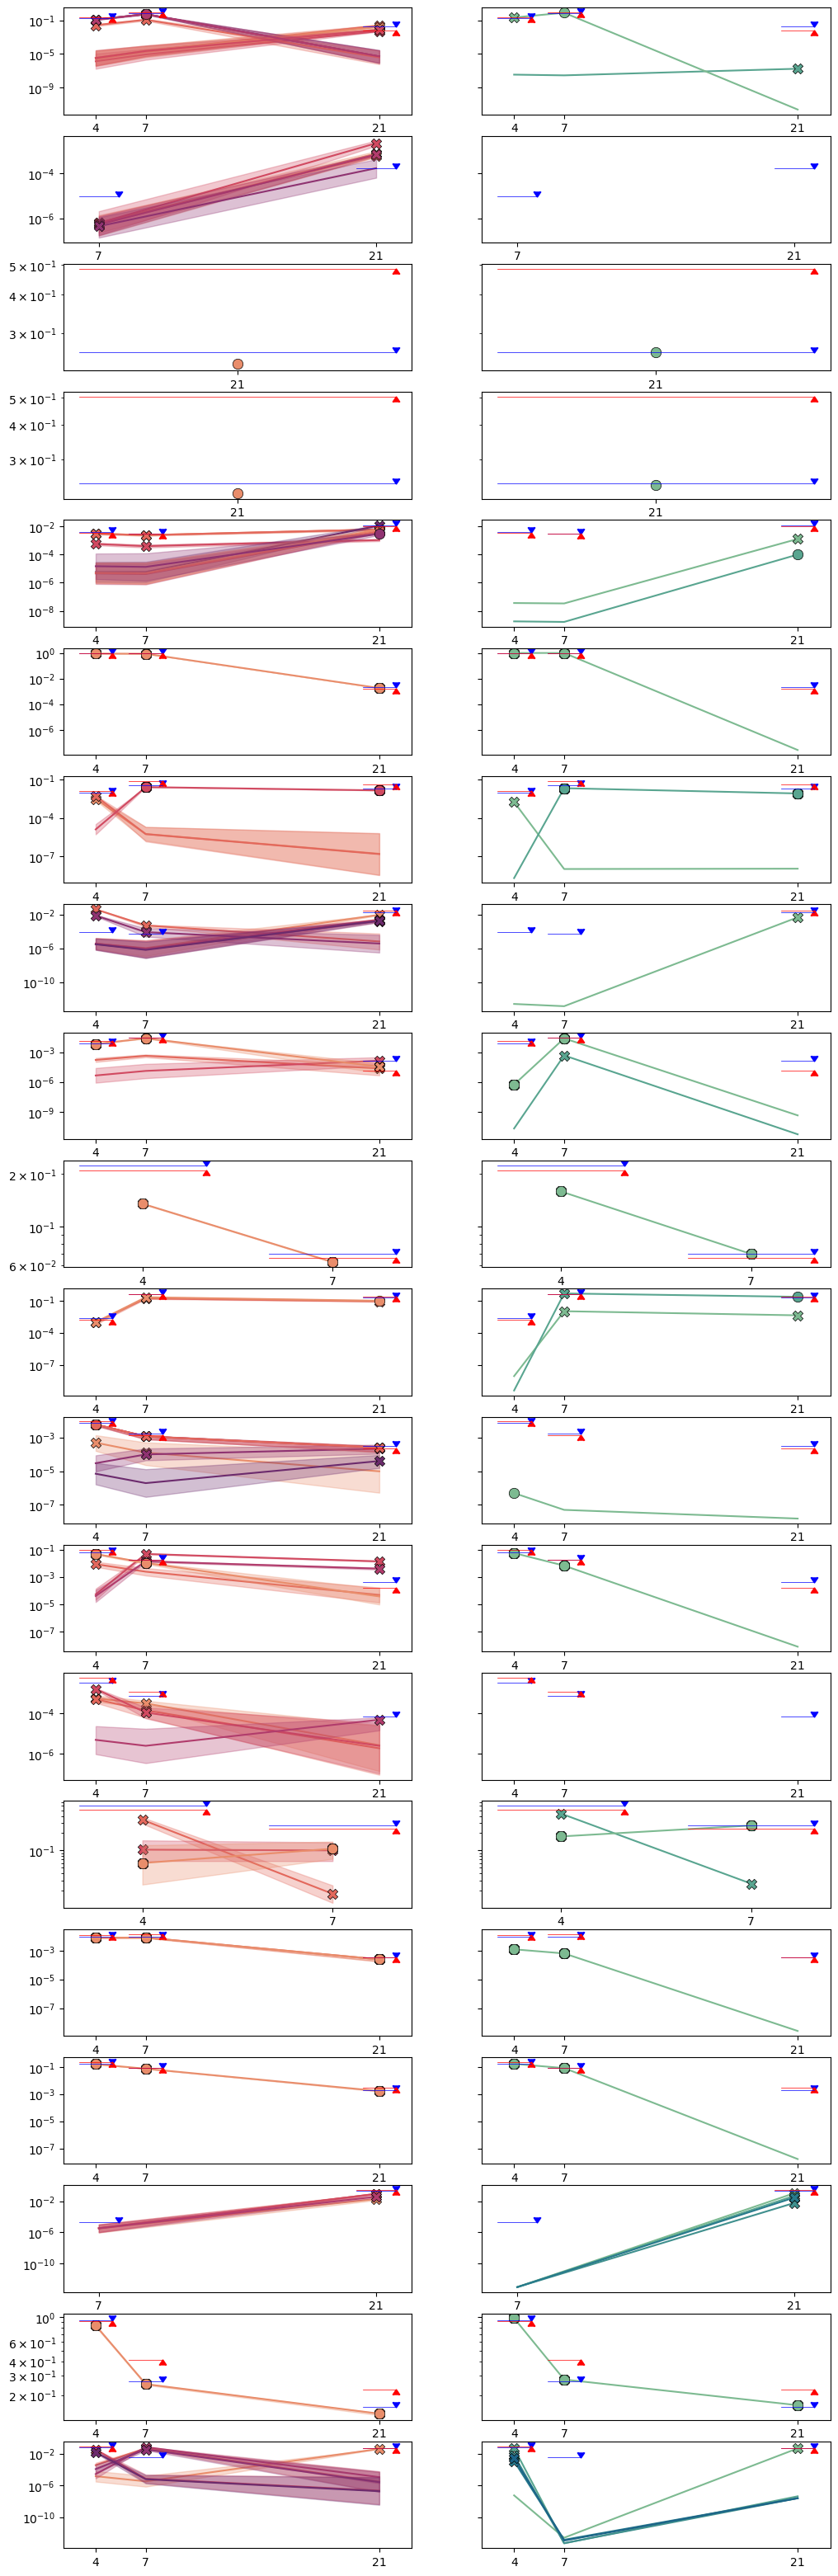

In [695]:
n_rows = 20
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 40), sharey='row')

delivery_mode = 'Vaginal'
for i, (_, row) in enumerate(infant_delivery.loc[infant_delivery['Delivery_mode'] == 'Vaginal'].iterrows()):
    infant_id = row['Individual']
    if i >= n_rows:
        break

    plot_chronostrain(infant_id, plot_config.chronostrain['coarse_default'].key, axes[i, 0], sb.color_palette("flare"), dfs_to_plot['chronostrain:coarse_default'], plot_config.chronostrain['coarse_default'].posterior)
    plot_mgems(infant_id, axes[i, 1], sb.color_palette("crest"), dfs_to_plot['mgems:coarse'], marker_enforce_demix_ub=2)
    
    plot_third_party_species_estimates(infant_id, axes[i, 0], bracken_estimates, marker_color='blue', arrow_direction='down')
    plot_third_party_species_estimates(infant_id, axes[i, 1], bracken_estimates, marker_color='blue', arrow_direction='down')
    plot_third_party_species_estimates(infant_id, axes[i, 0], metaphlan_estimates, marker_color='red', arrow_direction='up')
    plot_third_party_species_estimates(infant_id, axes[i, 1], metaphlan_estimates, marker_color='red', arrow_direction='up')

    print(infant_id)
    axes[i, 0].set_yscale('log')
    axes[i, 1].set_yscale('log')

In [756]:
_cs_res = dfs_to_plot['chronostrain:coarse_default'][6]  # do index 5 for raw, unfiltered estimates.
_ms_res = dfs_to_plot['mgems:coarse'][6]

_cs_res = _cs_res.loc[
    (_cs_res['Genus'] == 'Enterococcus') & (_cs_res['Species'] == 'faecalis')
]

def estimate_turnover(res_df, infant_id):
    res_df = res_df.loc[
        (res_df['Infant'] == infant_id)
    ]
    top_1 = res_df.sort_values(['Abund', 'Cluster']).groupby("T").tail(1).sort_values('T')

    if top_1.shape[0] == 0:
        return 0
        
    dominant_strain = top_1.head(1)['Cluster'].item()
    turnover = 0
    for _, row in top_1.iterrows():
        if row['Cluster'] != dominant_strain:
            dominant_strain = row['Cluster']
            turnover += 1
    if infant_id == 'B00178':
        display(top_1)
    return turnover

turnover_entries = []
for infant_id in all_infant_ids:   #{'A01077', 'B00053', 'B02273'}:
    # turnover = # of times dominant strain switched.
    cs_turnover = estimate_turnover(_cs_res, infant_id)
    ms_turnover = estimate_turnover(_ms_res, infant_id)
    turnover_entries.append({
        'Infant': infant_id,
        'TurnOverCS': cs_turnover,
        'TurnOverMS': ms_turnover
    })
    # turnover_entries.append({
    #     'Infant': infant_id,
    #     'TurnOver': cs_turnover,
    #     'Method': 'CS'
    # })
    # turnover_entries.append({
    #     'Infant': infant_id,
    #     'TurnOver': ms_turnover,
    #     'Method': 'MS'
    # })
turnover_df = pd.DataFrame(turnover_entries).merge(
    infant_delivery,
    left_on='Infant', right_on='Individual', how='inner'
)[['Infant', 'TurnOverCS', 'TurnOverMS', 'Delivery_mode']]
del turnover_entries

display(turnover_df)

,Infant,Cluster,T,Genus,Species,Abund,AbundOverall,Posterior,ClusterSize
96299,B00178,26975_1#40,4.0,Enterococcus,faecalis,0.231271,0.000008,0.987560,73
96278,B00178,GCA_902164855,7.0,Enterococcus,faecalis,0.271525,0.000067,0.991797,8
96301,B00178,26975_1#40,21.0,Enterococcus,faecalis,0.410388,0.001141,0.987560,73


,Infant,TurnOverCS,TurnOverMS,Delivery_mode
0,A00021_T1,0,0,Caesarean
1,A00021_T2,0,0,Caesarean
2,A00031,0,0,Caesarean
3,A00043,1,1,Vaginal
4,A00067,1,0,Vaginal
...,...,...,...,...
184,C02566,0,0,Caesarean
185,C02571,0,0,Vaginal
186,C02695,0,0,Vaginal
187,C02756,0,0,Caesarean


In [747]:
print("CS vs MS [Caesarean births, one-sided]:")
print(scipy.stats.wilcoxon(
    turnover_df.loc[turnover_df['Delivery_mode'] == 'Caesarean', 'TurnOverCS'], 
    turnover_df.loc[turnover_df['Delivery_mode'] == 'Caesarean', 'TurnOverMS'], 
    alternative='greater'
))

print("CS vs MS [Vaginal births, one-sided]:")
print(scipy.stats.wilcoxon(
    turnover_df.loc[turnover_df['Delivery_mode'] == 'Vaginal', 'TurnOverCS'], 
    turnover_df.loc[turnover_df['Delivery_mode'] == 'Vaginal', 'TurnOverMS'], 
    alternative='greater'
))

print("Caesarian vs Vaginal births [ChronoStrain, one-sided]:")
print(scipy.stats.mannwhitneyu(
    turnover_df.loc[turnover_df['Delivery_mode'] == 'Vaginal', 'TurnOverCS'], 
    turnover_df.loc[turnover_df['Delivery_mode'] == 'Caesarean', 'TurnOverCS'], 
    alternative='less'
))

print("Caesarian vs Vaginal births [mGEMS, one-sided]:")
print(scipy.stats.mannwhitneyu(
    turnover_df.loc[turnover_df['Delivery_mode'] == 'Vaginal', 'TurnOverMS'], 
    turnover_df.loc[turnover_df['Delivery_mode'] == 'Caesarean', 'TurnOverMS'], 
    alternative='less'
))

CS vs MS [Caesarean births, one-sided]:
WilcoxonResult(statistic=98.0, pvalue=0.0008081111075299929)
CS vs MS [Vaginal births, one-sided]:
WilcoxonResult(statistic=45.0, pvalue=0.001946208561389314)
Caesarian vs Vaginal births [ChronoStrain, one-sided]:
MannwhitneyuResult(statistic=4101.0, pvalue=0.21067591315833795)
Caesarian vs Vaginal births [mGEMS, one-sided]:
MannwhitneyuResult(statistic=4053.0, pvalue=0.08961705257526353)


<Axes: xlabel='Method', ylabel='Turnover'>

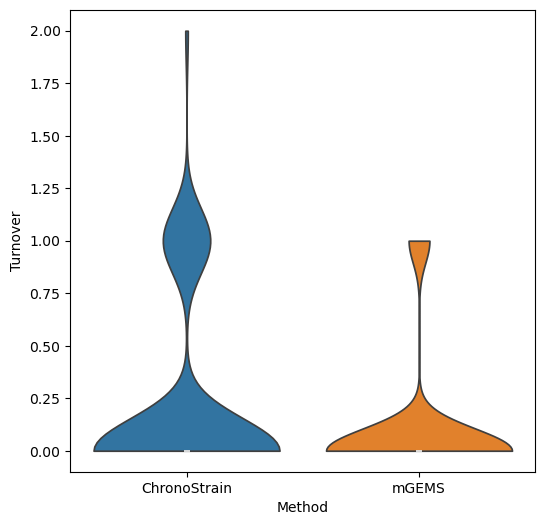

In [752]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sb.violinplot(
    pd.concat([
        turnover_df[['Infant', 'TurnOverCS']].rename(columns={'TurnOverCS': 'Turnover'}).assign(Method='ChronoStrain'),
        turnover_df[['Infant', 'TurnOverMS']].rename(columns={'TurnOverMS': 'Turnover'}).assign(Method='mGEMS')
    ]),
    hue='Method', x='Method',
    y='Turnover',
    ax=ax,
    cut=0
)

In [754]:
turnover_df.sort_values('TurnOverCS')

,Infant,TurnOverCS,TurnOverMS,Delivery_mode
0,A00021_T1,0,0,Caesarean
118,B02005,0,0,Caesarean
119,B02118,0,0,Vaginal
121,B02211,0,0,Vaginal
122,B02215,0,0,Caesarean
...,...,...,...,...
25,A01301,1,1,Caesarean
142,C01331,1,1,Caesarean
94,B00562_T2,1,0,Caesarean
48,A02133,2,0,Vaginal
